## This code takes in a .json file from the TweetyBERT Decoder. It: 
1) Graphs the phrase duration over each day, and draws a red dashed line for the surgery date.
2) Groups the data into 3 groups with equal numbers of songs: a) "early pre-lesion", b) "late pre-lesion", and c) post-lesion, then graphs violin/scatter plots of each group's phrase duration distribution. It then does a K-S statistic to compare the distance between the distributions, as well as a p-value. IT WILL ALSO DO MULTIPLE COMPARISON CORRECTION using Boneroni or Benjamini-Hochberg test.

### Step 1: Load in the .csv file and .json file. Use .json file to correct the years/date of the recordings, and load the surgery_day.

In [1]:
import json
import pandas as pd
import ast
from datetime import datetime

class temp:
    def __init__(self):
        # Define the path to the JSON file
        recording_file_path_name = '/Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/USA5506_decoded_database.json'

        # Read the JSON file
        print(f"Reading JSON file: {recording_file_path_name}")
        with open(recording_file_path_name, 'r') as f:
            decoder_data = json.load(f)['results']  # Adjusted to extract the 'results' key

        # Print the total number of songs (assuming each item in 'results' is a song)
        print(f"Total songs in JSON: {len(decoder_data)}")

        # Convert to DataFrame
        decoder_dataframe = pd.DataFrame(decoder_data)
        decoder_dataframe['syllable_onsets_offsets_ms'] = decoder_dataframe['syllable_onsets_offsets_ms'].apply(self.parse_json_safe)
        decoder_dataframe['syllable_onsets_offsets_timebins'] = decoder_dataframe['syllable_onsets_offsets_timebins'].apply(self.parse_json_safe)

        self.dataframe = decoder_dataframe

    def return_dataframe(self):
        return self.dataframe


    def parse_json_safe(self, s):
            """
            Safely parse a string representation of a JSON object.
            Handles extra quotes and converts single quotes to double quotes.
            """
            if isinstance(s, dict):
                return s  # If it's already a dictionary, return it as is
            
            if pd.isna(s):
                return {}
            
            # Remove surrounding single quotes
            s = s.strip()
            if s.startswith("''") and s.endswith("''"):
                s = s[2:-2]
            elif s.startswith("'") and s.endswith("'"):
                s = s[1:-1]
            
            if not s:
                return {}
            
            try:
                # First, attempt to parse using json
                s_json = s.replace("'", '"')
                return json.loads(s_json)
            except json.JSONDecodeError:
                try:
                    # If json fails, attempt using ast.literal_eval
                    return ast.literal_eval(s)
                except (ValueError, SyntaxError) as e:
                    print(f"Error parsing string: {s}\nError: {e}")
                    return {}
    
TEMP = temp()

decoder_dataframe = TEMP.return_dataframe()

print(decoder_dataframe.head)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Reading JSON file: /Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/USA5506_decoded_database.json
Total songs in JSON: 12154
<bound method NDFrame.head of                                       file_name        creation_date  \
0      USA5506_45700.49992595_2_12_13_53_12.wav  2025-02-12T13:53:38   
1      USA5506_45700.50054645_2_12_13_54_14.wav  2025-02-12T13:54:36   
2      USA5506_45700.50081602_2_12_13_54_41.wav  2025-02-12T13:55:00   
3       USA5506_45700.50100051_2_1

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import json

# Load the CSV and JSON creation_date data
save_output_to_this_file_path = '/Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/graph_outputs'
# USE IF THE DECODER OUTPUT A CSV FILE:
#recording_file_path_name = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/DECODER_csvs_and_jsons/USA5509_decoded.csv'
#decoder_dataframe = pd.read_csv(recording_file_path_name)
#USE IF THE DECODER OUTPUT IS A .JSON FILE:
# recording_file_path_name = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/DECODER_sham_lesions/USA5271_decoded.json'
# print(f"Reading JSON file: {recording_file_path_name}")
# with open(recording_file_path_name, 'r') as f:
#     decoder_data = json.load(f)['results']  # Adjusted to extract the 'results' key
# # Convert to DataFrame
# decoder_dataframe = pd.DataFrame(decoder_data)

path_to_json_file_with_dates = '/Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/USA5506_Comp2_creation_data.json'


with open(path_to_json_file_with_dates, 'r') as f:
    json_data = json.load(f)
    # Extract surgery date and format it
json_surgery_date = json_data['treatment_date']  # Assuming single treatment date
date_obj = datetime.strptime(json_surgery_date, "%Y-%m-%d")
surgery_date = date_obj.strftime("%Y.%m.%d")  # Adjust to year-first format for consistency
print(f"Surgery date: {surgery_date}")
# Extract subdirectory creation dates from JSON data
subdirectory_dates = {subdir: data['subdirectory_creation_date'] for subdir, data in json_data['subdirectories'].items()}


# Function to extract date, time, and animal_id from the file name
def find_recording_dates_and_times(recording_file_path_name):
    try:
        file_name = recording_file_path_name.split('/')[-1]
        split_file_name_by_underscores = file_name.split('_')
        animal_id = split_file_name_by_underscores[0]
        month = split_file_name_by_underscores[2].zfill(2)
        day = split_file_name_by_underscores[3].zfill(2)
        date = f"{month}.{day}"
        hour = split_file_name_by_underscores[4].zfill(2)
        minute = split_file_name_by_underscores[5].zfill(2)
        second = split_file_name_by_underscores[6].replace('.wav', '').zfill(2)
        return animal_id, date, hour, minute, second
    except IndexError:
        print(f"Error: Unexpected format in file name {recording_file_path_name}")
        return None, None, None, None, None

# Function to update the date with year from the JSON file
def update_date_with_year(row, subdirectory_dates):
    month_day = row['Date']
    month = month_day.split('.')[0]
    for subdir, date in subdirectory_dates.items():
        year, json_month, json_day = date.split('-')
        if json_month == month:
            # Return the date in the format YYYY.MM.DD
            return f"{year}.{month_day}"
    return None

# Function to create a table and filter data where song_present is True
def make_table(input_data_frame, subdirectory_dates):
    only_song_data = input_data_frame[input_data_frame['song_present'] == True].reset_index(drop=True)
    num_files_with_song = only_song_data.shape[0]
    
    organized_data_frame = only_song_data.copy()
    organized_data_frame['Animal ID'] = [None] * num_files_with_song
    organized_data_frame['Date'] = [None] * num_files_with_song
    organized_data_frame['Hour'] = [None] * num_files_with_song
    organized_data_frame['Minute'] = [None] * num_files_with_song
    organized_data_frame['Second'] = [None] * num_files_with_song

    for i, row in only_song_data.iterrows():
        recording_file_path_name = row['file_name']
        try:
            animal_id, date, hour, minute, second = find_recording_dates_and_times(recording_file_path_name)
            organized_data_frame.at[i, 'Animal ID'] = animal_id
            organized_data_frame.at[i, 'Date'] = date
            organized_data_frame.at[i, 'Hour'] = hour
            organized_data_frame.at[i, 'Minute'] = minute
            organized_data_frame.at[i, 'Second'] = second
        except Exception as e:
            print(f"Error processing file {recording_file_path_name}: {e}")
            continue

    # Apply the year correction to the date
    organized_data_frame['Date'] = organized_data_frame.apply(lambda row: update_date_with_year(row, subdirectory_dates), axis=1)
    
    # Convert the updated 'Date' column to a proper datetime object for further handling
    organized_data_frame['Date'] = pd.to_datetime(organized_data_frame['Date'], format='%Y.%m.%d', errors='coerce')
    
    print(f"First rows of organized_data_frame with updated dates: {organized_data_frame.head(3)}")
    return organized_data_frame

# Generate the organized data table
organized_data_frame = make_table(decoder_dataframe, subdirectory_dates)

# Find the unique dates from the recording
def find_unique_recording_dates(data_frame):
    # Extract the unique values from the 'Date' column
    unique_dates = data_frame['Date'].dt.strftime('%Y.%m.%d').unique()  # Convert back to string for display purposes
    return unique_dates

# Example usage
unique_dates = find_unique_recording_dates(organized_data_frame)
print("Unique recording dates:", unique_dates)

# ### Clean syllable labels formatting, then find the unique syllable labels in the dataframe
# def clean_and_convert_to_dict(row):
#     try:
#         # Strip leading and trailing single quotes and whitespace
#         row_cleaned = row.strip("''").strip()
#         # Replace single quotes with double quotes for valid JSON syntax
#         row_cleaned = row_cleaned.replace("'", '"')
#         # Convert the cleaned string to a dictionary
#         return json.loads(row_cleaned)
#     except json.JSONDecodeError as e:
#         print(f"JSON decoding failed for row: {row}\nError: {e}")
#         return None  # Return None or some default value if decoding fails

# Apply the function to all rows in the 'syllable_onsets_offsets_ms' column
organized_data_frame['syllable_onsets_offsets_ms_dict'] = organized_data_frame['syllable_onsets_offsets_ms']

# Now 'syllable_onsets_offsets_ms_dict' contains the cleaned and converted dictionaries
# Create a set to store all unique syllable labels
unique_syllable_labels = set()

# Iterate through each row in the 'syllable_onsets_offsets_ms_dict' column
for row in organized_data_frame['syllable_onsets_offsets_ms_dict']:
    if row:  # Check if the row is not None or empty
        # Add the keys (syllable labels) to the set
        unique_syllable_labels.update(row.keys())

# Convert the set to a sorted list (optional, for easier viewing)
unique_syllable_labels = sorted(unique_syllable_labels)

# Print or return the unique syllable labels
print("Unique syllable labels:", unique_syllable_labels)


Surgery date: 2025.03.04
First rows of organized_data_frame with updated dates:                                   file_name        creation_date  \
0  USA5506_45700.49992595_2_12_13_53_12.wav  2025-02-12T13:53:38   
1  USA5506_45700.50054645_2_12_13_54_14.wav  2025-02-12T13:54:36   
2  USA5506_45700.50081602_2_12_13_54_41.wav  2025-02-12T13:55:00   

   song_present                         syllable_onsets_offsets_ms  \
0          True  {'6': [[0.0, 2242.3809523809527], [2663.333333...   
1          True  {'6': [[0.0, 1454.4444444444446]], '5': [[1454...   
2          True  {'8': [[0.0, 787.936507936508]], '6': [[787.93...   

                    syllable_onsets_offsets_timebins Animal ID       Date  \
0  {'6': [[0.0, 831], [987.0, 990], [990.99999999...   USA5506 2025-02-12   
1  {'6': [[0.0, 539]], '5': [[539.0, 1128]], '4':...   USA5506 2025-02-12   
2  {'8': [[0.0, 292]], '6': [[292.0, 315], [355.0...   USA5506 2025-02-12   

  Hour Minute Second  
0   13     53     12  
1   13     

### Step 4: Find the syllable durations in every song for eacy unique syllable label.

In [3]:
# Create a set to store all unique syllable labels
unique_syllable_labels = set()

# First, find all unique syllable labels from the 'syllable_onsets_offsets_ms_dict' column
for row in organized_data_frame['syllable_onsets_offsets_ms_dict']:
    if row:  # Check if the row is not None or empty
        unique_syllable_labels.update(row.keys())

# Function to calculate durations of a specific syllable's phrases
def calculate_syllable_durations(syllable_dict, syllable_label):
    if syllable_label in syllable_dict:
        # Get the list of [onset, offset] pairs for the syllable
        intervals = syllable_dict[syllable_label]
        # Calculate the duration of each interval
        durations = [offset - onset for onset, offset in intervals]
        return durations
    else:
        return []  # Return an empty list if the syllable label is not present

# Iterate over each unique syllable and add a new column for its durations
for syllable_label in unique_syllable_labels:
    column_name = f'syllable_{syllable_label}_durations'
    organized_data_frame[column_name] = organized_data_frame['syllable_onsets_offsets_ms_dict'].apply(
        lambda x: calculate_syllable_durations(x, syllable_label) if x else []
    )

# Check the updated DataFrame with new duration columns for each syllable
print(organized_data_frame.columns)
#print(organized_data_frame['syllable_21_durations'][0])

Index(['file_name', 'creation_date', 'song_present',
       'syllable_onsets_offsets_ms', 'syllable_onsets_offsets_timebins',
       'Animal ID', 'Date', 'Hour', 'Minute', 'Second',
       'syllable_onsets_offsets_ms_dict', 'syllable_18_durations',
       'syllable_5_durations', 'syllable_15_durations', 'syllable_2_durations',
       'syllable_19_durations', 'syllable_8_durations',
       'syllable_17_durations', 'syllable_4_durations',
       'syllable_14_durations', 'syllable_7_durations', 'syllable_1_durations',
       'syllable_13_durations', 'syllable_11_durations',
       'syllable_9_durations', 'syllable_12_durations', 'syllable_3_durations',
       'syllable_0_durations', 'syllable_10_durations',
       'syllable_16_durations', 'syllable_6_durations'],
      dtype='object')


### Step 5: Grouping by days, graph the duration of each syllable over each day of recording.

In [4]:
# import os
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Ensure the Date column is in datetime format
# organized_data_frame['Date'] = pd.to_datetime(organized_data_frame['Date'])

# # Get the earliest and latest dates in the DataFrame
# earliest_date = organized_data_frame['Date'].min()
# latest_date = organized_data_frame['Date'].max()

# # Generate a full list of all dates between the earliest and latest recording date
# full_date_range = pd.date_range(start=earliest_date, end=latest_date)

# # Prepare the data by exploding the 'syllable_21_durations' list into individual rows
# exploded_data = organized_data_frame[['Date', 'syllable_21_durations']].explode('syllable_21_durations')
# exploded_data['syllable_21_durations'] = pd.to_numeric(exploded_data['syllable_21_durations'], errors='coerce')
# exploded_data = exploded_data.dropna(subset=['syllable_21_durations'])

# # Ensure the surgery date is in datetime format
# surgery_date_dt = pd.to_datetime(surgery_date, format='%Y.%m.%d')

# # Convert surgery date to string in the same format as the x-axis (YYYY-MM-DD)
# surgery_date_str = surgery_date_dt.strftime('%Y-%m-%d')

# # Set up the plotting environment (no gridlines)
# plt.figure(figsize=(20, 6))
# sns.set(style="white")  # Removes the gridlines

# # Initialize the plot
# for current_date in full_date_range:
#     # Filter the data for the current date
#     daily_data = exploded_data[exploded_data['Date'] == current_date]

#     # If there is no data for the current date, skip to the next date
#     if daily_data.empty:
#         continue

#     # Create a violin plot for the current day with updated `density_norm`
#     sns.violinplot(x='Date', y='syllable_21_durations', data=daily_data, inner="quartile", density_norm="width", color="lightgray")

#     # Overlay a scatter plot (strip plot) with jitter for better visibility of individual points
#     sns.stripplot(x='Date', y='syllable_21_durations', data=daily_data, jitter=True, size=5, color="blue", alpha=0.7)

# # Add a dashed red vertical line at the surgery date (in string format)
# plt.axvline(x=surgery_date_str, color='red', linestyle='--', label='Surgery Date')

# # Customize the plot
# animal_id = organized_data_frame['Animal ID'].iloc[0]
# plt.title(f'Distribution of Syllable 21 Phrase Durations Across Recording Dates\nAnimal ID: {animal_id}', fontsize=18)
# plt.xlabel('Recording Date', fontsize=14)
# plt.ylabel('Phrase Duration (ms)', fontsize=14)
# plt.xticks(ticks=range(len(full_date_range)), labels=[date.strftime('%Y-%m-%d') for date in full_date_range], rotation=90)

# # Add a legend to indicate the surgery date line
# plt.legend()

# # Define the folder to save the output
# save_output_to_this_file_path = '/Users/mirandahulsey-vincent/Desktop/DECODER_phrase_duration_graphs/USA5288'

# # Ensure the directory exists
# os.makedirs(save_output_to_this_file_path, exist_ok=True)

# # Save the figure as a PNG file, including the animal ID in the file name
# output_file_name = f"{save_output_to_this_file_path}/{animal_id}_syllable_21_phrase_duration_plot.png"
# plt.savefig(output_file_name, format='png', dpi=300)

# # Display the plot
# plt.tight_layout()
# plt.show()

# # Confirm file was saved
# print(f"Plot saved as: {output_file_name}")

In [5]:
# import os
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Ensure the Date column is in datetime format
# organized_data_frame['Date'] = pd.to_datetime(organized_data_frame['Date'])

# # Get the earliest and latest dates in the DataFrame
# earliest_date = organized_data_frame['Date'].min()
# latest_date = organized_data_frame['Date'].max()

# # Generate a full list of all dates between the earliest and latest recording date
# full_date_range = pd.date_range(start=earliest_date, end=latest_date)

# # Ensure the surgery date is in datetime format
# surgery_date_dt = pd.to_datetime(surgery_date, format='%Y.%m.%d')

# # Convert surgery date to string in the same format as the x-axis (YYYY-MM-DD)
# surgery_date_str = surgery_date_dt.strftime('%Y-%m-%d')

# # Iterate over each syllable label in the unique_syllable_labels array
# for syllable_label in unique_syllable_labels:
#     # Prepare the column name for the current syllable label (assuming the column format is 'syllable_{label}_durations')
#     column_name = f'syllable_{syllable_label}_durations'
    
#     # Prepare the data for plotting by exploding the column into individual rows
#     exploded_data = organized_data_frame[['Date', column_name]].explode(column_name)
    
#     # Convert durations to numeric, handle errors, and drop missing values
#     exploded_data[column_name] = pd.to_numeric(exploded_data[column_name], errors='coerce')
#     exploded_data = exploded_data.dropna(subset=[column_name])

#     # Set up the plotting environment (no gridlines)
#     plt.figure(figsize=(20, 6))
#     sns.set(style="white")  # Removes the gridlines

#     # Initialize the plot
#     for current_date in full_date_range:
#         # Filter the data for the current date
#         daily_data = exploded_data[exploded_data['Date'] == current_date]

#         # If there is no data for the current date, skip to the next date
#         if daily_data.empty:
#             continue

#         # Create a violin plot for the current day with updated `density_norm`
#         sns.violinplot(x='Date', y=column_name, data=daily_data, inner="quartile", density_norm="width", color="lightgray")

#         # Overlay a scatter plot (strip plot) with jitter for better visibility of individual points
#         sns.stripplot(x='Date', y=column_name, data=daily_data, jitter=True, size=5, color="blue", alpha=0.7)

#     # Add a dashed red vertical line at the surgery date (in string format)
#     plt.axvline(x=surgery_date_str, color='red', linestyle='--', label='Surgery Date')

#     # Customize the plot
#     animal_id = organized_data_frame['Animal ID'].iloc[0]
#     plt.title(f'Distribution of Syllable {syllable_label} Phrase Durations Across Recording Dates\nAnimal ID: {animal_id}', fontsize=18)
#     plt.xlabel('Recording Date', fontsize=14)
#     plt.ylabel('Phrase Duration (ms)', fontsize=14)
#     plt.xticks(ticks=range(len(full_date_range)), labels=[date.strftime('%Y-%m-%d') for date in full_date_range], rotation=90)

#     # Add a legend to indicate the surgery date line
#     plt.legend()

#     # Define the folder to save the output
#     save_output_to_this_file_path = '/Users/mirandahulsey-vincent/Desktop/DECODER_phrase_duration_graphs/USA5288'

#     # Ensure the directory exists
#     os.makedirs(save_output_to_this_file_path, exist_ok=True)

#     # Save the figure as a PNG file, including the syllable label and animal ID in the file name
#     output_file_name = f"{save_output_to_this_file_path}/{animal_id}_syllable_{syllable_label}_phrase_duration_plot.png"
#     plt.savefig(output_file_name, format='png', dpi=300)

#     # Display the plot
#     plt.tight_layout()
#     plt.show()

#     # Confirm file was saved
#     print(f"Plot for syllable {syllable_label} saved as: {output_file_name}")


### Step 6: Use the surgery_date to generate equal-sized groups: early pre-lesion, late pre-lesion, and post-lesion. Graph the distribution of sylalbles.

In [6]:
# Function to calculate group size based on pre- and post-lesion song counts
def calculate_group_size(organized_data_frame, surgery_date):
    # Filter the DataFrame for songs recorded before and after the lesion date
    pre_lesion_songs = organized_data_frame[organized_data_frame['Date'] < surgery_date]
    post_lesion_songs = organized_data_frame[organized_data_frame['Date'] > surgery_date]
    
    # Count the number of pre-lesion and post-lesion songs
    num_pre_lesion_songs = pre_lesion_songs.shape[0]
    num_post_lesion_songs = post_lesion_songs.shape[0]
    
    # Determine the group size based on the condition
    if num_post_lesion_songs < 0.5 * num_pre_lesion_songs:
        group_size = num_post_lesion_songs  # Use the number of post-lesion songs as the group size
    else:
        group_size = int(0.5 * num_pre_lesion_songs)  # Use half the number of pre-lesion songs as the group size
    
    # Print the results
    print(f"Number of pre-lesion songs: {num_pre_lesion_songs}")
    print(f"Number of post-lesion songs: {num_post_lesion_songs}")
    print(f"Calculated group size: {group_size}")
    
    return group_size

# Function to divide the data into 3 groups with equal sizes
def divide_into_three_groups(organized_data_frame, surgery_date, group_size):
    # Ensure the Date column is in datetime format
    organized_data_frame['Date'] = pd.to_datetime(organized_data_frame['Date'])
    
    # Filter the DataFrame for songs recorded before and after the lesion date
    pre_lesion_songs = organized_data_frame[organized_data_frame['Date'] < surgery_date]
    post_lesion_songs = organized_data_frame[organized_data_frame['Date'] > surgery_date]

    # Divide pre-lesion songs into early and late groups based on the calculated group size
    early_pre_lesion_songs = pre_lesion_songs.iloc[:group_size]  # First group_size songs for early pre-lesion
    late_pre_lesion_songs = pre_lesion_songs.iloc[-group_size:]  # Last group_size songs for late pre-lesion

    # Take the first `group_size` number of post-lesion songs
    post_lesion_songs = post_lesion_songs.iloc[:group_size]

    # Print the results
    print(f"Early pre-lesion group size: {early_pre_lesion_songs.shape[0]}")
    print(f"Late pre-lesion group size: {late_pre_lesion_songs.shape[0]}")
    print(f"Post-lesion group size: {post_lesion_songs.shape[0]}")
    
    return early_pre_lesion_songs, late_pre_lesion_songs, post_lesion_songs

# Example usage
# Calculate the group size
group_size = calculate_group_size(organized_data_frame, surgery_date)

# Divide the data into 3 groups of equal size
early_pre_lesion, late_pre_lesion, post_lesion = divide_into_three_groups(organized_data_frame, surgery_date, group_size)

Number of pre-lesion songs: 2614
Number of post-lesion songs: 286
Calculated group size: 286
Early pre-lesion group size: 286
Late pre-lesion group size: 286
Post-lesion group size: 286


In [7]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# def plot_syllable_phrase_durations(early_pre_lesion, unique_syllable_labels):
#     # Set up the plotting environment
#     plt.figure(figsize=(12, 6))
#     sns.set(style="whitegrid")

#     # Prepare data for plotting
#     plot_data = pd.DataFrame()

#     for syllable_label in unique_syllable_labels:
#         # Create the column name based on the syllable label
#         column_name = f'syllable_{syllable_label}_durations'
        
#         # If the column exists in the dataset, add it to the plot data
#         if column_name in early_pre_lesion.columns:
#             # Explode the data for plotting, reset index to avoid duplicate labels, and add a 'Syllable' column for x-axis labels
#             exploded_data = early_pre_lesion[['Date', column_name]].explode(column_name).dropna().reset_index(drop=True)
#             exploded_data['Syllable'] = syllable_label
#             exploded_data['Phrase Duration (ms)'] = pd.to_numeric(exploded_data[column_name], errors='coerce')
            
#             # Concatenate exploded data with the main plot data, reset index to avoid issues with duplicate labels
#             plot_data = pd.concat([plot_data, exploded_data[['Syllable', 'Phrase Duration (ms)']]], axis=0).reset_index(drop=True)

#     # Create the violin plot to show the distribution of phrase durations for each syllable
#     sns.violinplot(x='Syllable', y='Phrase Duration (ms)', data=plot_data, inner="quartile", scale="width", color="lightgray")

#     # Customize the plot
#     plt.title('Distribution of Phrase Durations for Each Syllable (Early Pre-Lesion)', fontsize=18)
#     plt.xlabel('Syllable Label', fontsize=14)
#     plt.ylabel('Phrase Duration (ms)', fontsize=14)
#     plt.xticks(rotation=90)  # Rotate x-tick labels for readability

#     # Show the plot
#     plt.tight_layout()
#     plt.show()

# # Example usage
# plot_syllable_phrase_durations(early_pre_lesion, unique_syllable_labels)


In [8]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# def plot_syllable_phrase_durations(early_pre_lesion, unique_syllable_labels):
#     # Set up the plotting environment
#     plt.figure(figsize=(12, 6))
#     sns.set(style="whitegrid")

#     # Prepare data for plotting
#     plot_data = pd.DataFrame()

#     for syllable_label in unique_syllable_labels:
#         # Create the column name based on the syllable label
#         column_name = f'syllable_{syllable_label}_durations'
        
#         # If the column exists in the dataset, add it to the plot data
#         if column_name in early_pre_lesion.columns:
#             # Explode the data for plotting, reset index to avoid duplicate labels, and add a 'Syllable' column for x-axis labels
#             exploded_data = early_pre_lesion[['Date', column_name]].explode(column_name).dropna().reset_index(drop=True)
#             exploded_data['Syllable'] = int(syllable_label)  # Convert to integer for proper sorting
#             exploded_data['Phrase Duration (ms)'] = pd.to_numeric(exploded_data[column_name], errors='coerce')
            
#             # Concatenate exploded data with the main plot data, reset index to avoid issues with duplicate labels
#             plot_data = pd.concat([plot_data, exploded_data[['Syllable', 'Phrase Duration (ms)']]], axis=0).reset_index(drop=True)

#     # Sort syllables numerically before plotting
#     plot_data = plot_data.sort_values(by='Syllable')

#     # Create the violin plot to show the distribution of phrase durations for each syllable
#     sns.violinplot(x='Syllable', y='Phrase Duration (ms)', data=plot_data, inner="quartile", scale="width", color="lightgray")

#     # Customize the plot
#     plt.title('Distribution of Phrase Durations for Each Syllable (Early Pre-Lesion)', fontsize=18)
#     plt.xlabel('Syllable Label', fontsize=14)
#     plt.ylabel('Phrase Duration (ms)', fontsize=14)
#     plt.xticks(rotation=90)  # Rotate x-tick labels for readability

#     # Show the plot
#     plt.tight_layout()
#     plt.show()

# # Example usage
# plot_syllable_phrase_durations(early_pre_lesion, unique_syllable_labels)


In [9]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# def plot_syllable_phrase_durations(early_pre_lesion, unique_syllable_labels):
#     # Set up the plotting environment
#     plt.figure(figsize=(12, 6))
#     sns.set(style="whitegrid")

#     # Prepare data for plotting
#     plot_data = pd.DataFrame()

#     for syllable_label in unique_syllable_labels:
#         # Create the column name based on the syllable label
#         column_name = f'syllable_{syllable_label}_durations'
        
#         # If the column exists in the dataset, add it to the plot data
#         if column_name in early_pre_lesion.columns:
#             # Explode the data for plotting, reset index to avoid duplicate labels, and add a 'Syllable' column for x-axis labels
#             exploded_data = early_pre_lesion[['Date', column_name]].explode(column_name).dropna().reset_index(drop=True)
#             exploded_data['Syllable'] = int(syllable_label)  # Convert to integer for proper sorting
#             exploded_data['Phrase Duration (ms)'] = pd.to_numeric(exploded_data[column_name], errors='coerce')
            
#             # Concatenate exploded data with the main plot data, reset index to avoid issues with duplicate labels
#             plot_data = pd.concat([plot_data, exploded_data[['Syllable', 'Phrase Duration (ms)']]], axis=0).reset_index(drop=True)

#     # Sort syllables numerically before plotting
#     plot_data = plot_data.sort_values(by='Syllable')

#     # Create the violin plot to show the distribution of phrase durations for each syllable
#     sns.violinplot(x='Syllable', y='Phrase Duration (ms)', data=plot_data, inner="quartile", scale="width", color="lightgray")

#     # Overlay a scatterplot on top of the violin plot
#     sns.stripplot(x='Syllable', y='Phrase Duration (ms)', data=plot_data, jitter=True, size=5, color="blue", alpha=0.6)

#     # Customize the plot
#     plt.title('Distribution of Phrase Durations for Each Syllable (Early Pre-Lesion)', fontsize=18)
#     plt.xlabel('Syllable Label', fontsize=14)
#     plt.ylabel('Phrase Duration (ms)', fontsize=14)
#     plt.xticks(rotation=90)  # Rotate x-tick labels for readability

#     # Show the plot
#     plt.tight_layout()
#     plt.show()

# # Example usage
# plot_syllable_phrase_durations(early_pre_lesion, unique_syllable_labels)


In [10]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# def plot_syllable_phrase_durations(dataset, unique_syllable_labels, title_suffix, y_min, y_max, group_size):
#     # Set up the plotting environment
#     plt.figure(figsize=(12, 6))
#     sns.set(style="whitegrid")

#     # Prepare data for plotting
#     plot_data = pd.DataFrame()

#     for syllable_label in unique_syllable_labels:
#         # Create the column name based on the syllable label
#         column_name = f'syllable_{syllable_label}_durations'
        
#         # If the column exists in the dataset, add it to the plot data
#         if column_name in dataset.columns:
#             # Explode the data for plotting, reset index to avoid duplicate labels, and add a 'Syllable' column for x-axis labels
#             exploded_data = dataset[['Date', column_name]].explode(column_name).dropna().reset_index(drop=True)
#             exploded_data['Syllable'] = int(syllable_label)  # Convert to integer for proper sorting
#             exploded_data['Phrase Duration (ms)'] = pd.to_numeric(exploded_data[column_name], errors='coerce')
            
#             # Concatenate exploded data with the main plot data, reset index to avoid issues with duplicate labels
#             plot_data = pd.concat([plot_data, exploded_data[['Syllable', 'Phrase Duration (ms)']]], axis=0).reset_index(drop=True)

#     # Sort syllables numerically before plotting
#     plot_data = plot_data.sort_values(by='Syllable')

#     # Create the violin plot to show the distribution of phrase durations for each syllable
#     sns.violinplot(x='Syllable', y='Phrase Duration (ms)', data=plot_data, inner="quartile", scale="width", color="lightgray")

#     # Overlay a scatterplot on top of the violin plot
#     sns.stripplot(x='Syllable', y='Phrase Duration (ms)', data=plot_data, jitter=True, size=5, color="blue", alpha=0.6)

#     # Set the y-axis limits to the common y-axis range
#     plt.ylim(y_min, y_max)

#     # Customize the plot
#     plt.title(f'Distribution of Phrase Durations for Each Syllable {title_suffix} (N={group_size} songs)', fontsize=18)
#     plt.xlabel('Syllable Label', fontsize=14)
#     plt.ylabel('Phrase Duration (ms)', fontsize=14)
#     plt.xticks(rotation=90)  # Rotate x-tick labels for readability

#     # Show the plot
#     plt.tight_layout()
#     plt.show()

# # Calculate global y-axis range across all datasets
# def calculate_y_axis_range(datasets, unique_syllable_labels):
#     all_durations = []

#     for dataset in datasets:
#         for syllable_label in unique_syllable_labels:
#             column_name = f'syllable_{syllable_label}_durations'
#             if column_name in dataset.columns:
#                 # Collect all phrase durations
#                 all_durations.extend(dataset[column_name].explode().dropna().tolist())

#     # Determine the global min and max for y-axis limits
#     y_min = min(all_durations)
#     y_max = max(all_durations)
    
#     return y_min, y_max

# # Example usage: Calculate y-axis limits and plot for each dataset
# datasets = [early_pre_lesion, late_pre_lesion, post_lesion]
# y_min, y_max = calculate_y_axis_range(datasets, unique_syllable_labels)

# # Get the group size (number of songs) for each dataset
# early_group_size = early_pre_lesion.shape[0]
# late_group_size = late_pre_lesion.shape[0]
# post_group_size = post_lesion.shape[0]

# # Generate the graphs for early, late, and post-lesion datasets with the same y-axis scale
# plot_syllable_phrase_durations(early_pre_lesion, unique_syllable_labels, "Early Pre-Lesion", y_min, y_max, early_group_size)
# plot_syllable_phrase_durations(late_pre_lesion, unique_syllable_labels, "Late Pre-Lesion", y_min, y_max, late_group_size)
# plot_syllable_phrase_durations(post_lesion, unique_syllable_labels, "Post-Lesion", y_min, y_max, post_group_size)

## Graph, keeping the y axis the same for each syllable:

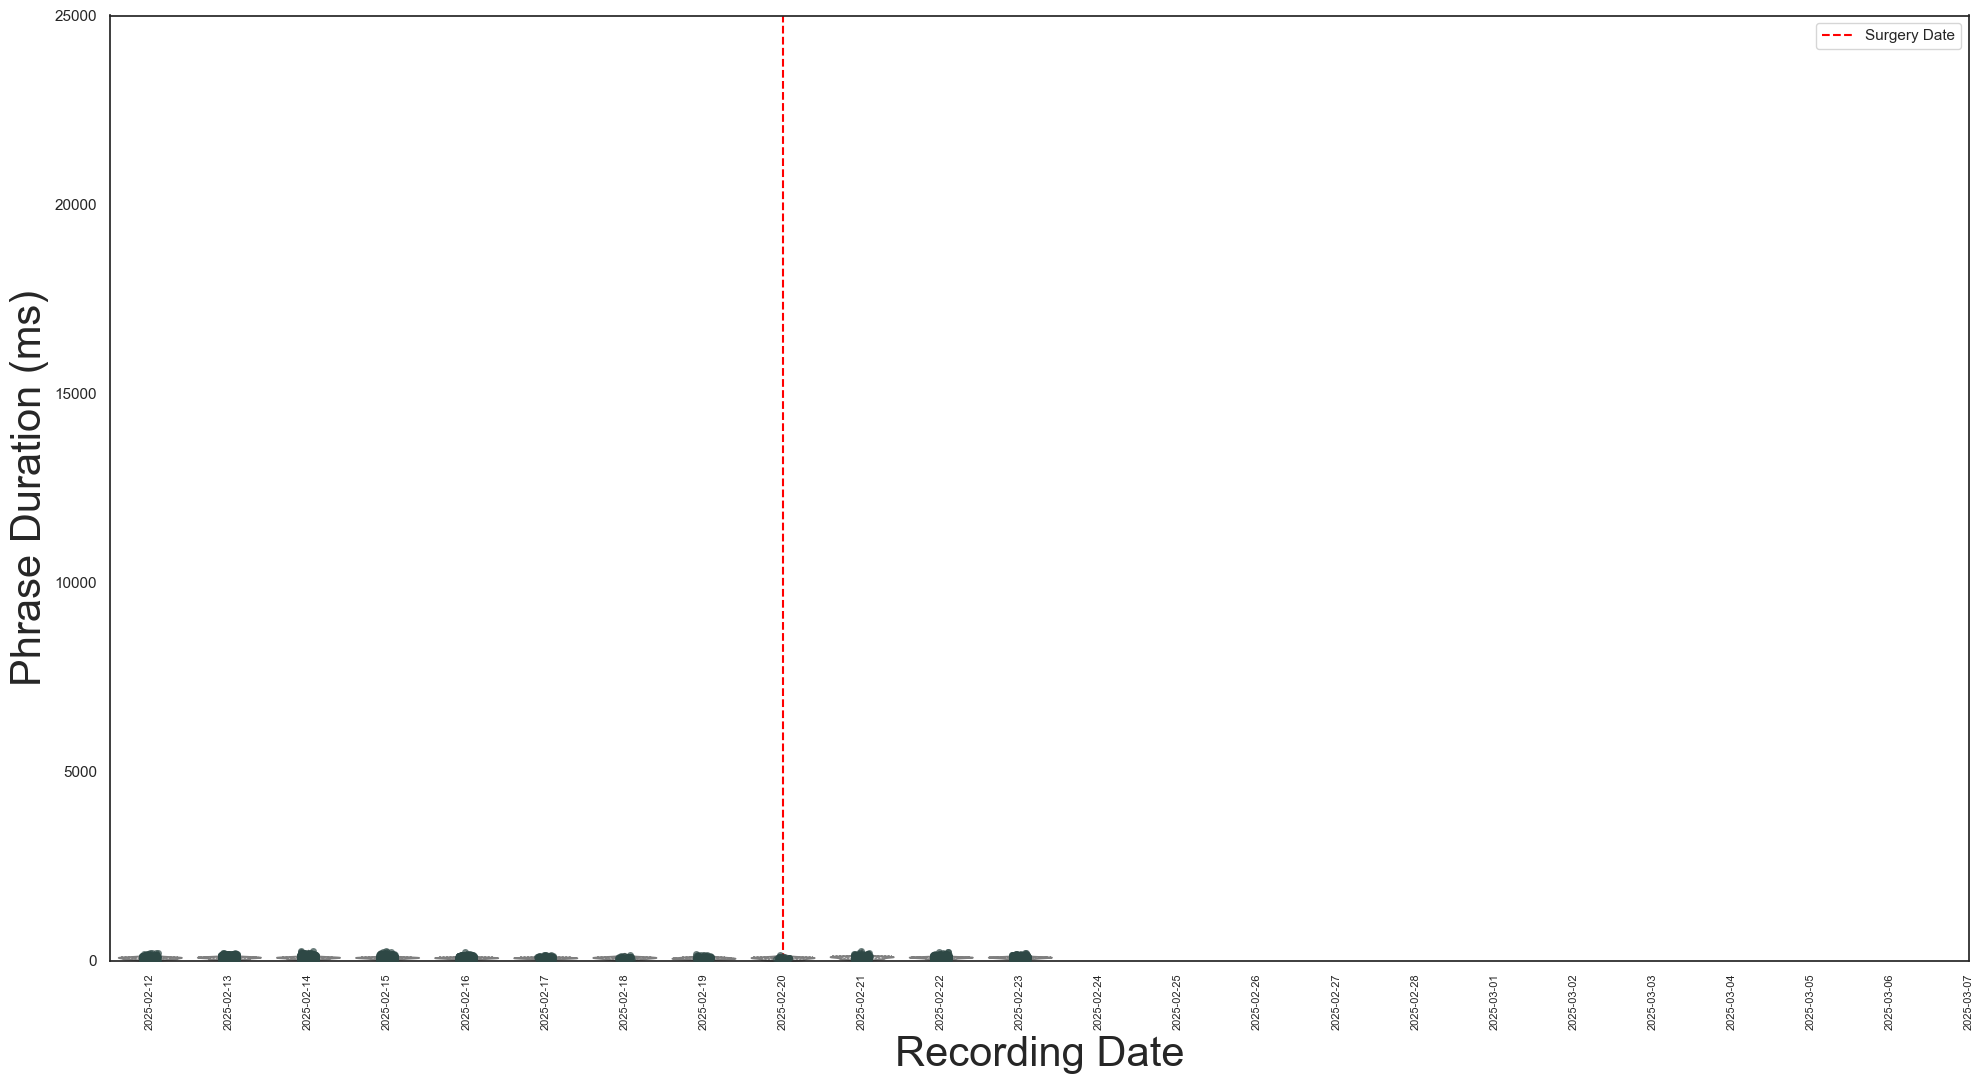

Plot for syllable 18 saved as: /Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/graph_outputs/USA5506_syllable_18_phrase_duration_plot.png


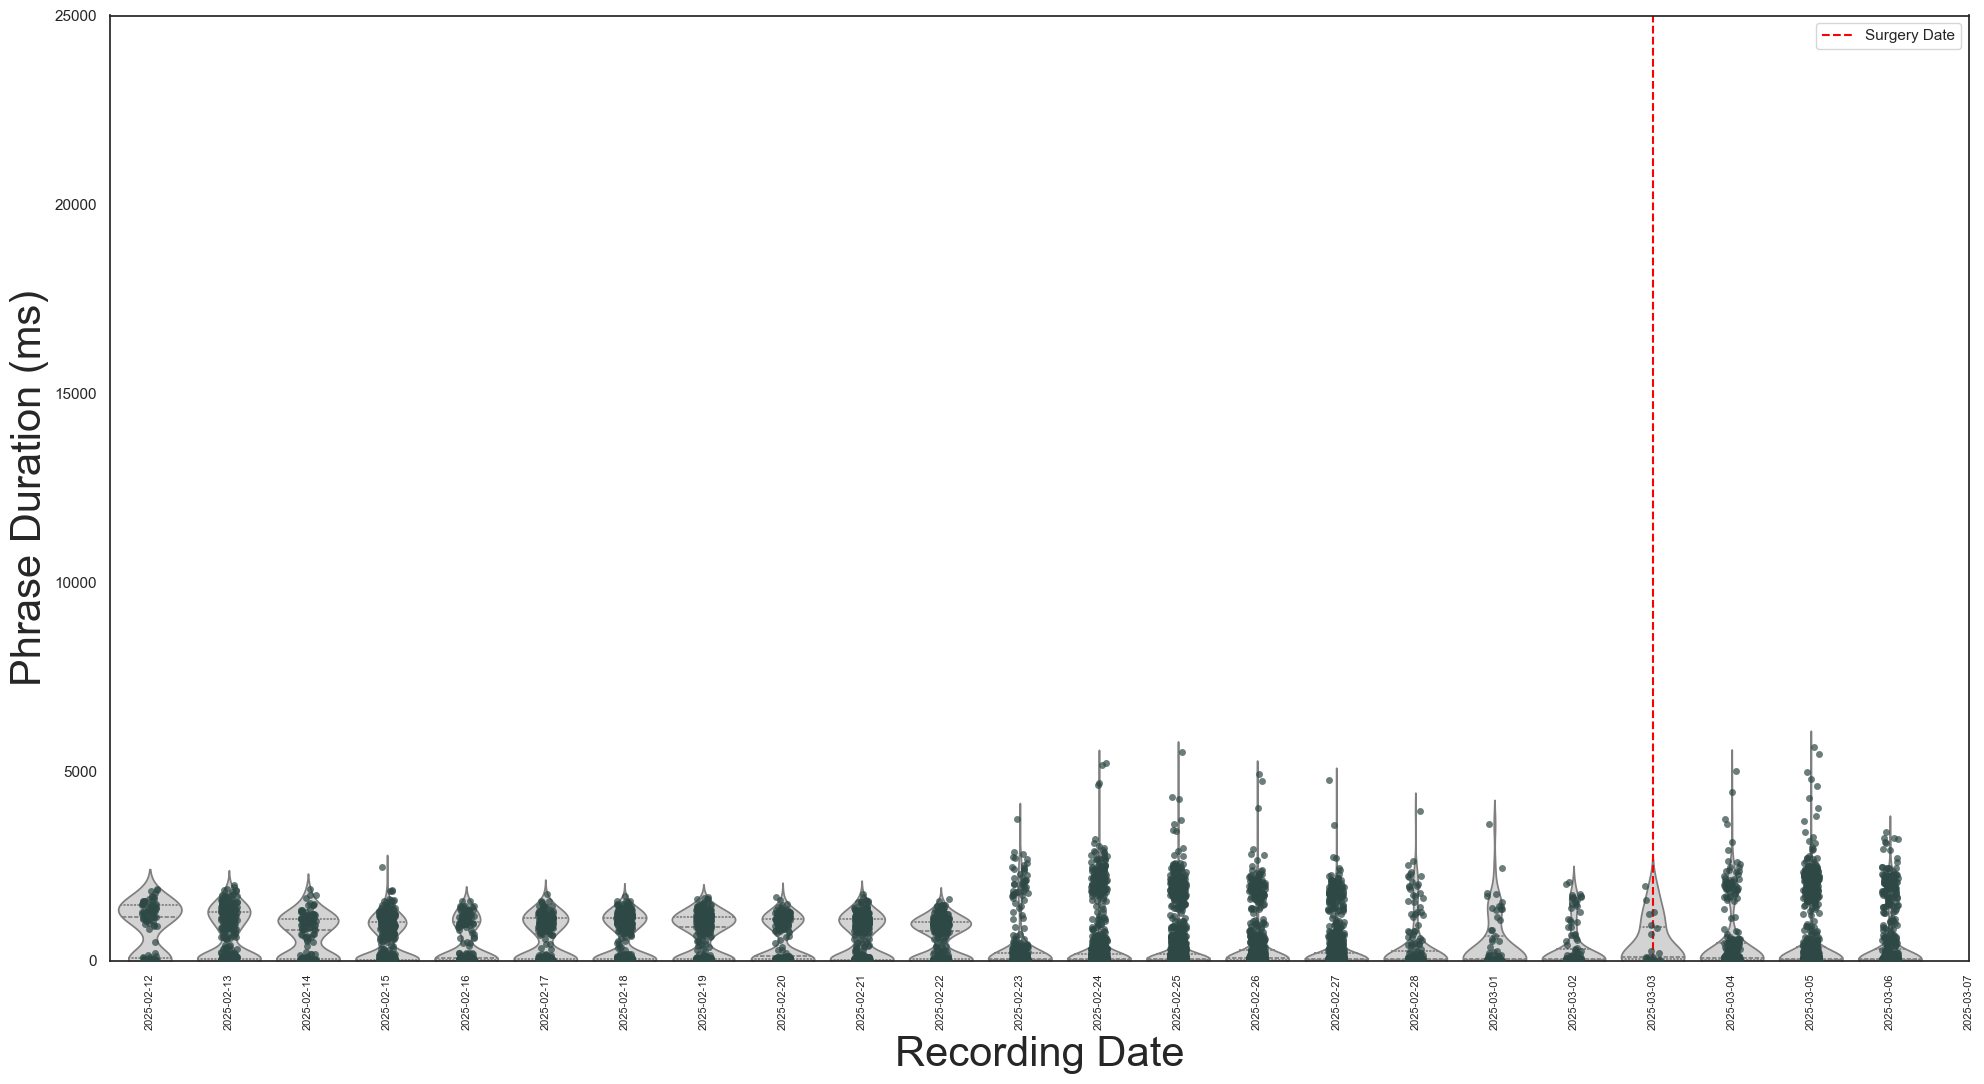

Plot for syllable 5 saved as: /Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/graph_outputs/USA5506_syllable_5_phrase_duration_plot.png


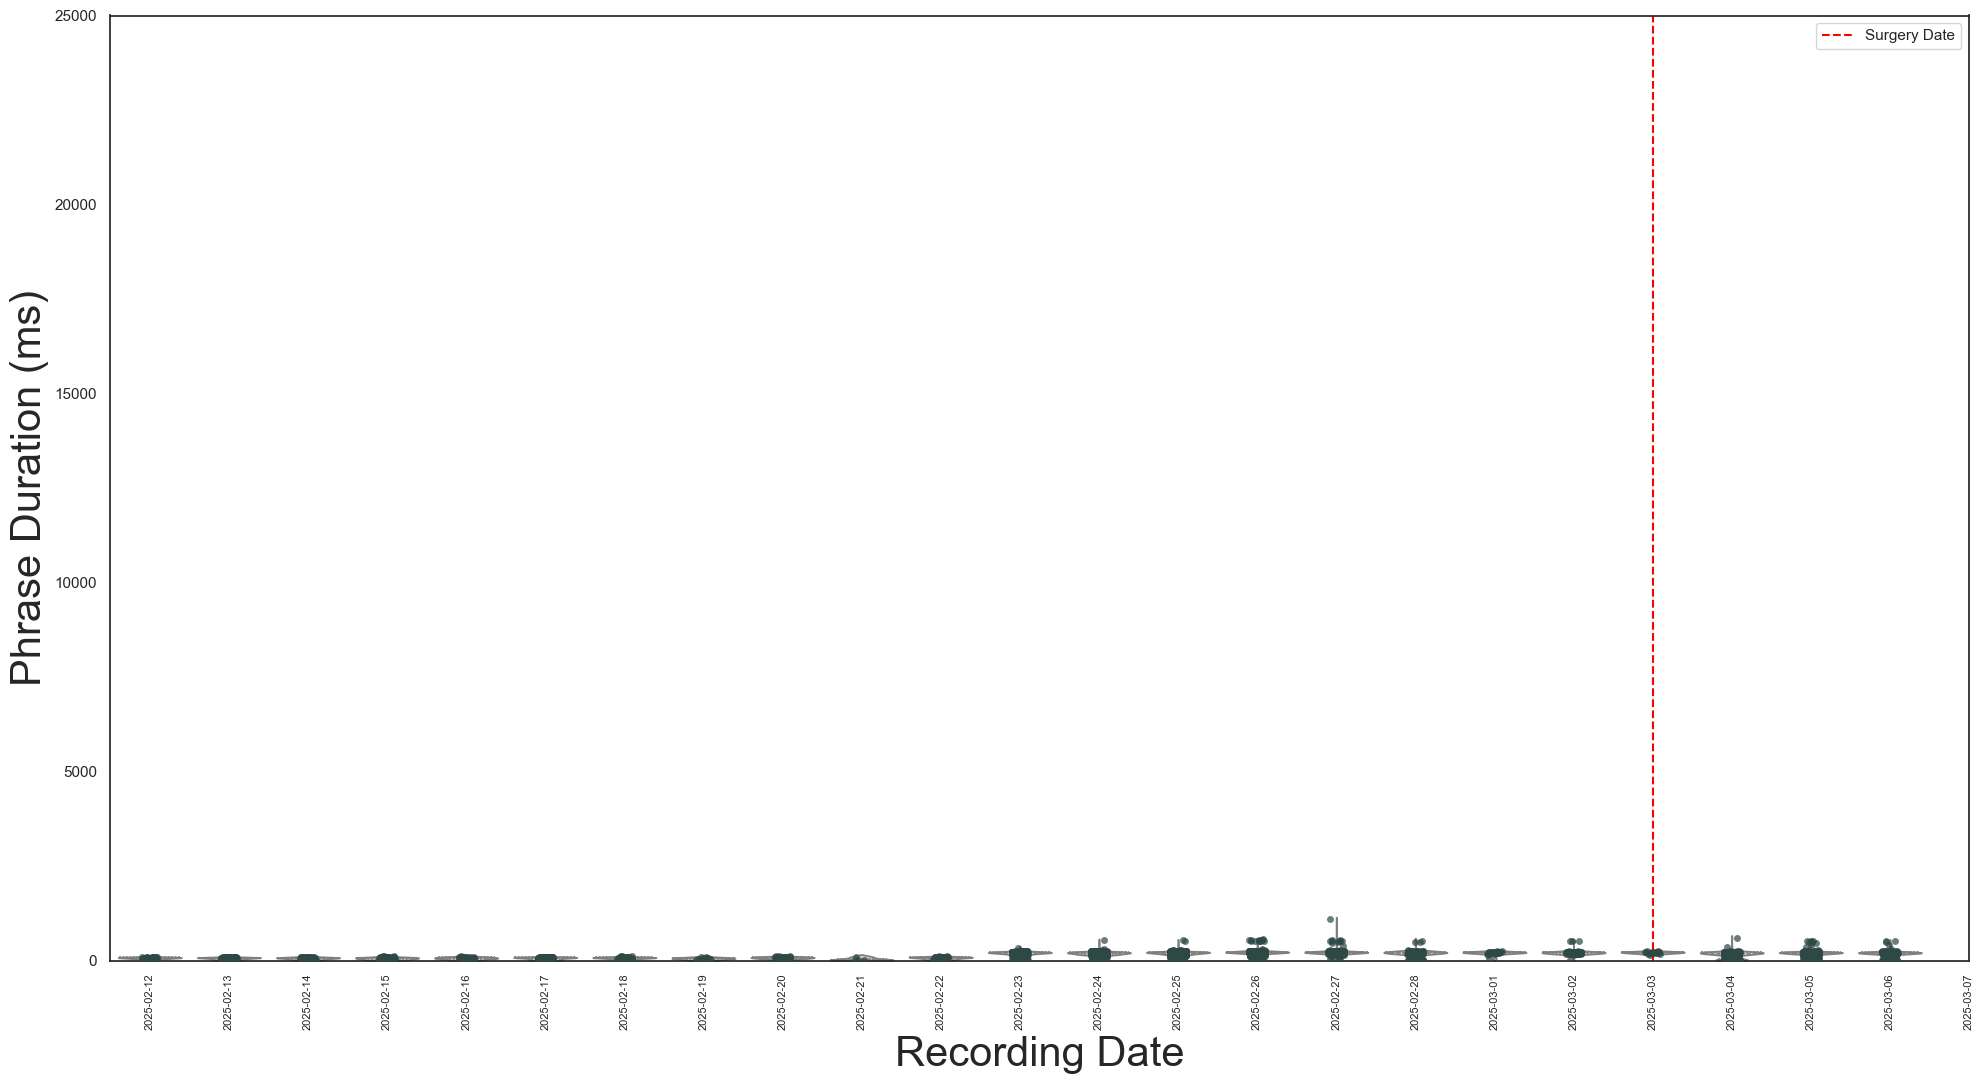

Plot for syllable 15 saved as: /Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/graph_outputs/USA5506_syllable_15_phrase_duration_plot.png


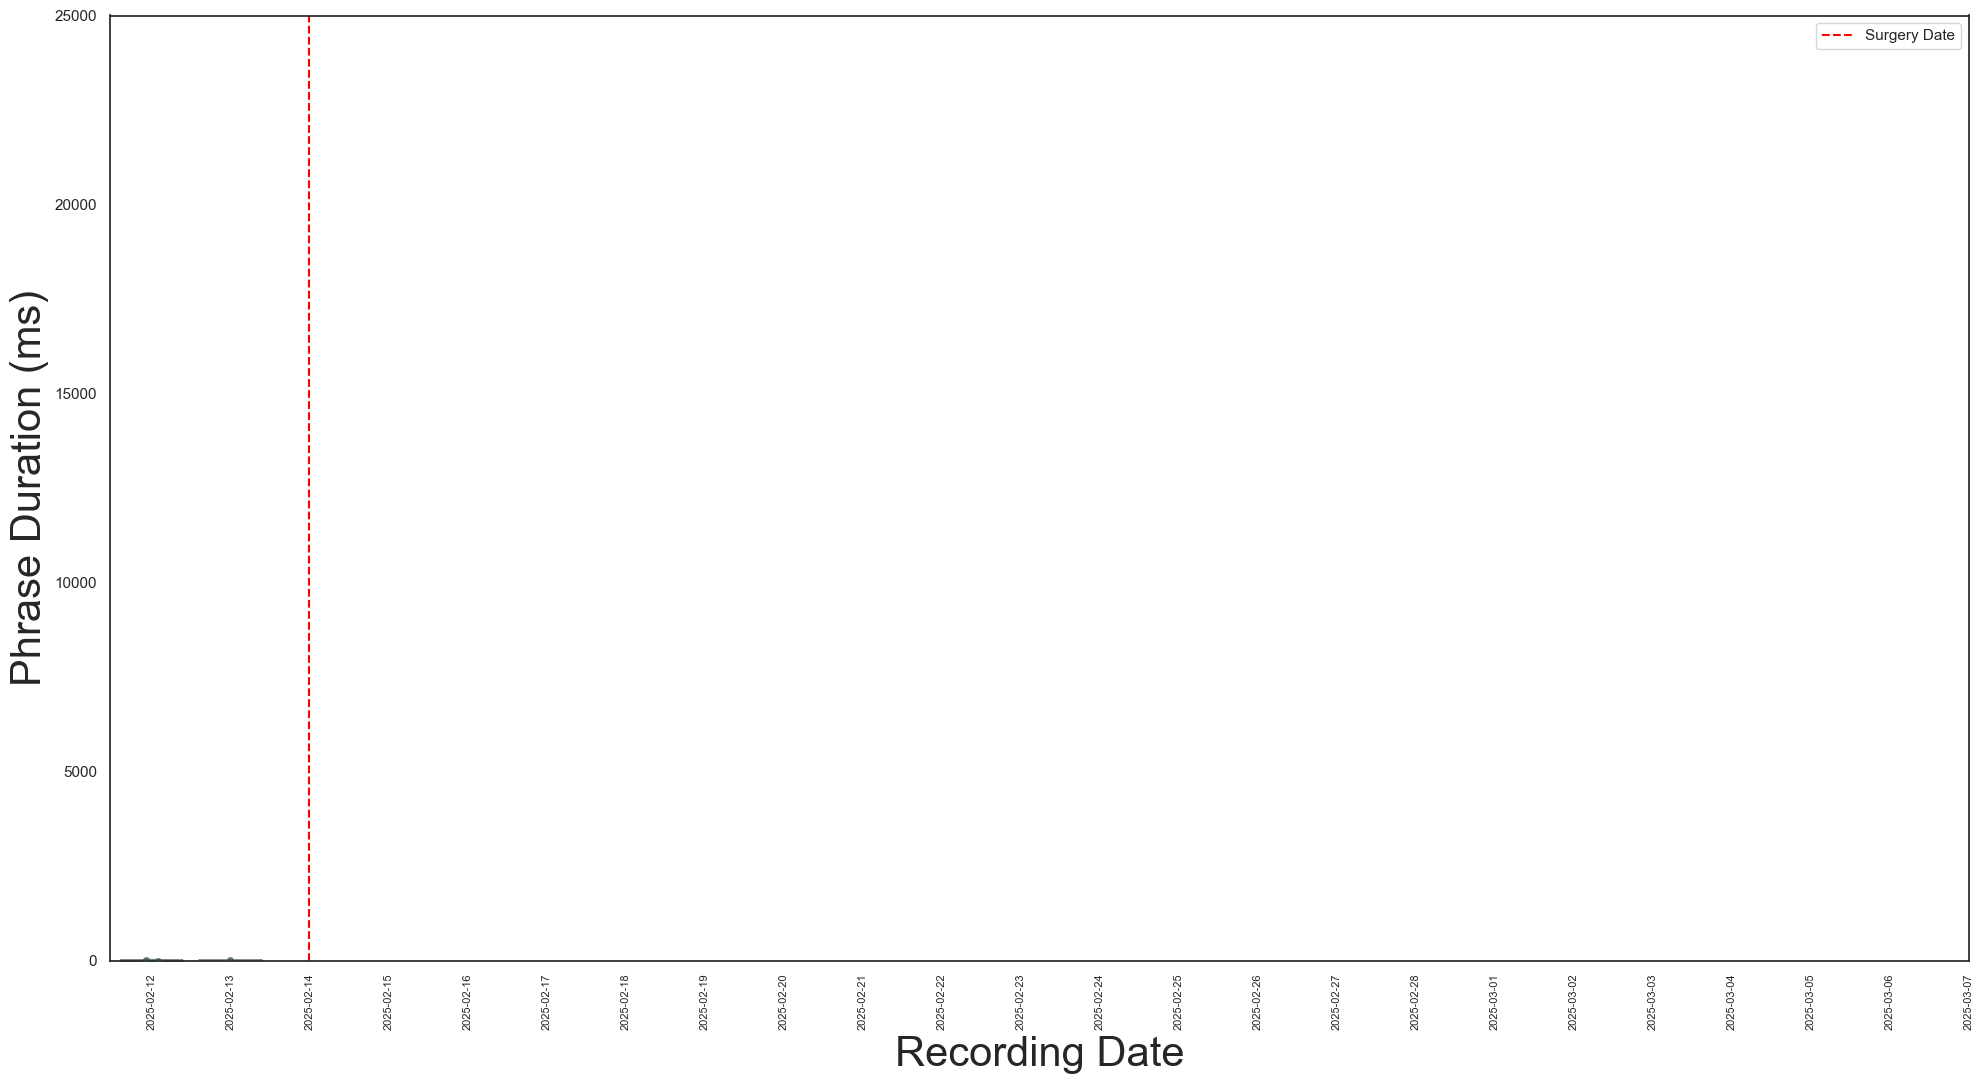

Plot for syllable 2 saved as: /Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/graph_outputs/USA5506_syllable_2_phrase_duration_plot.png


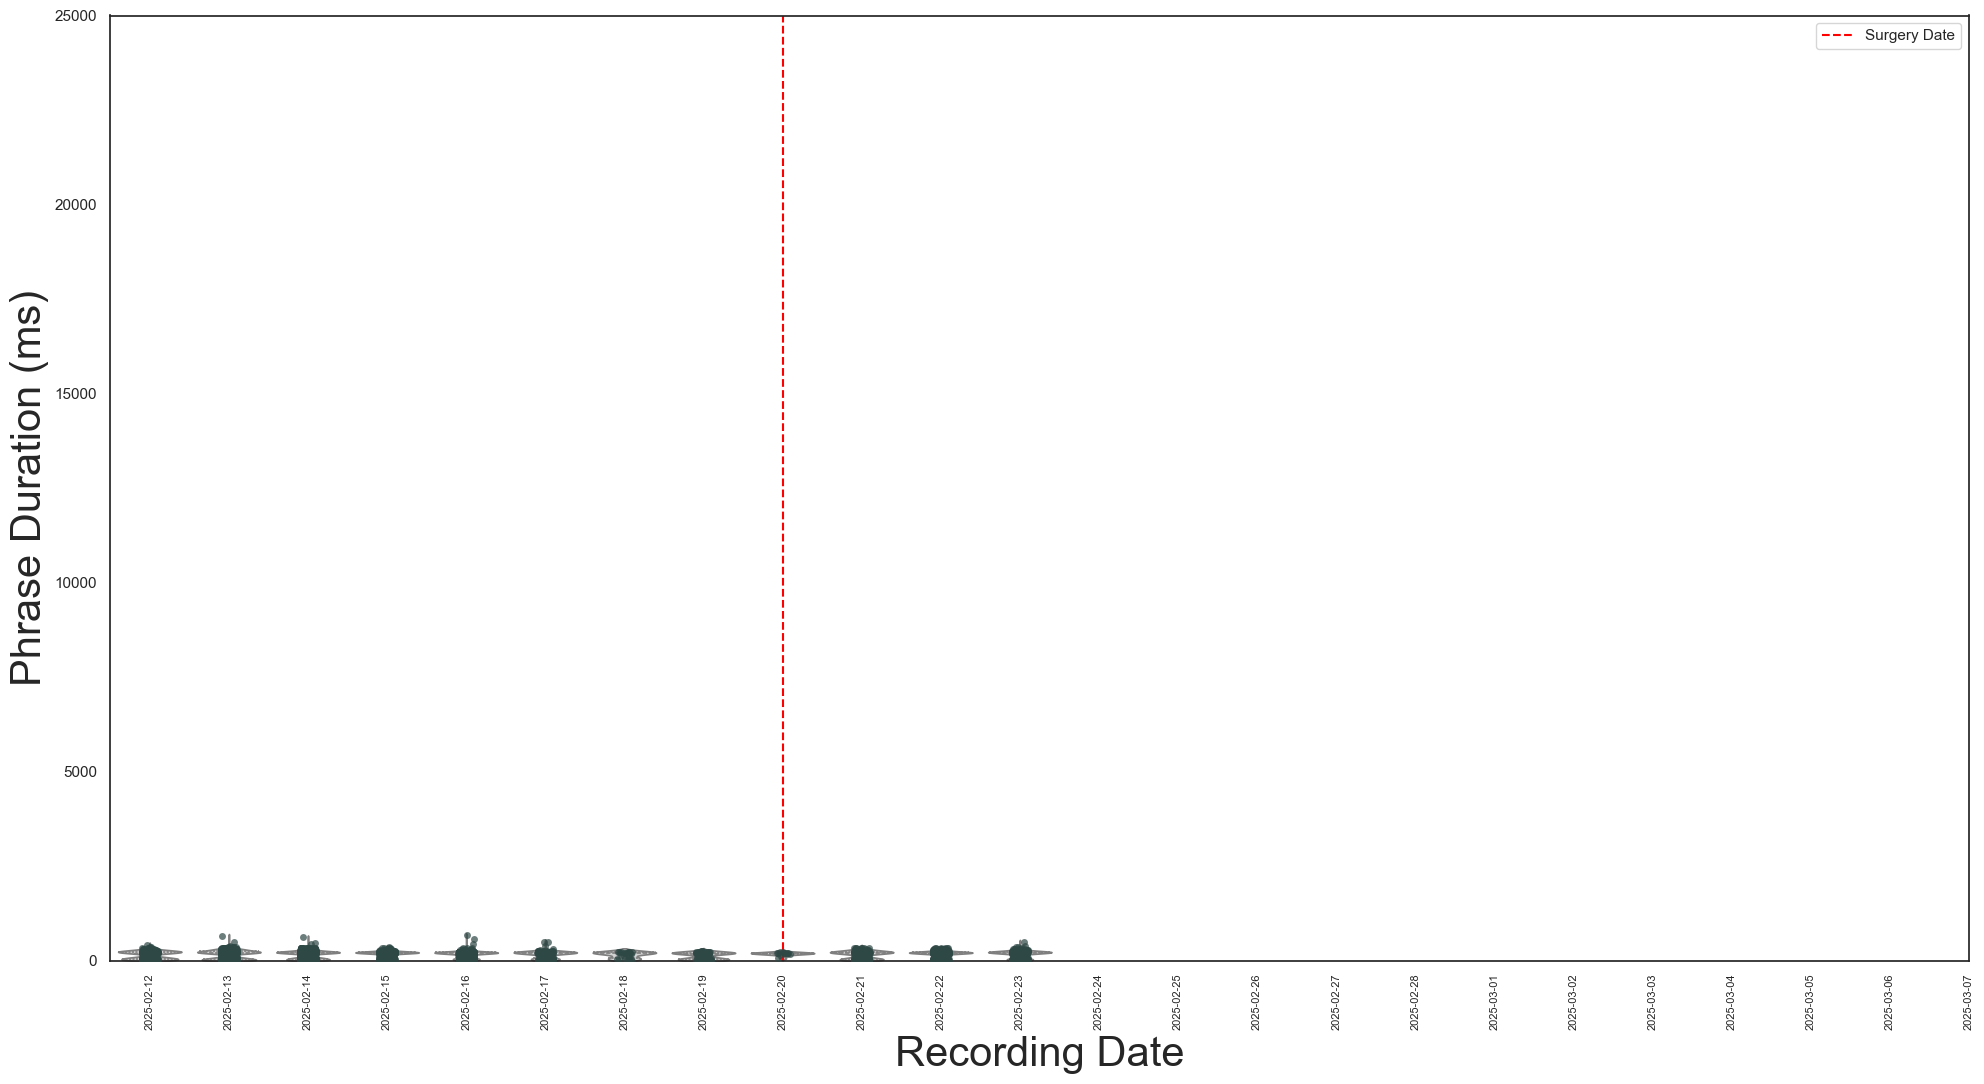

Plot for syllable 19 saved as: /Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/graph_outputs/USA5506_syllable_19_phrase_duration_plot.png


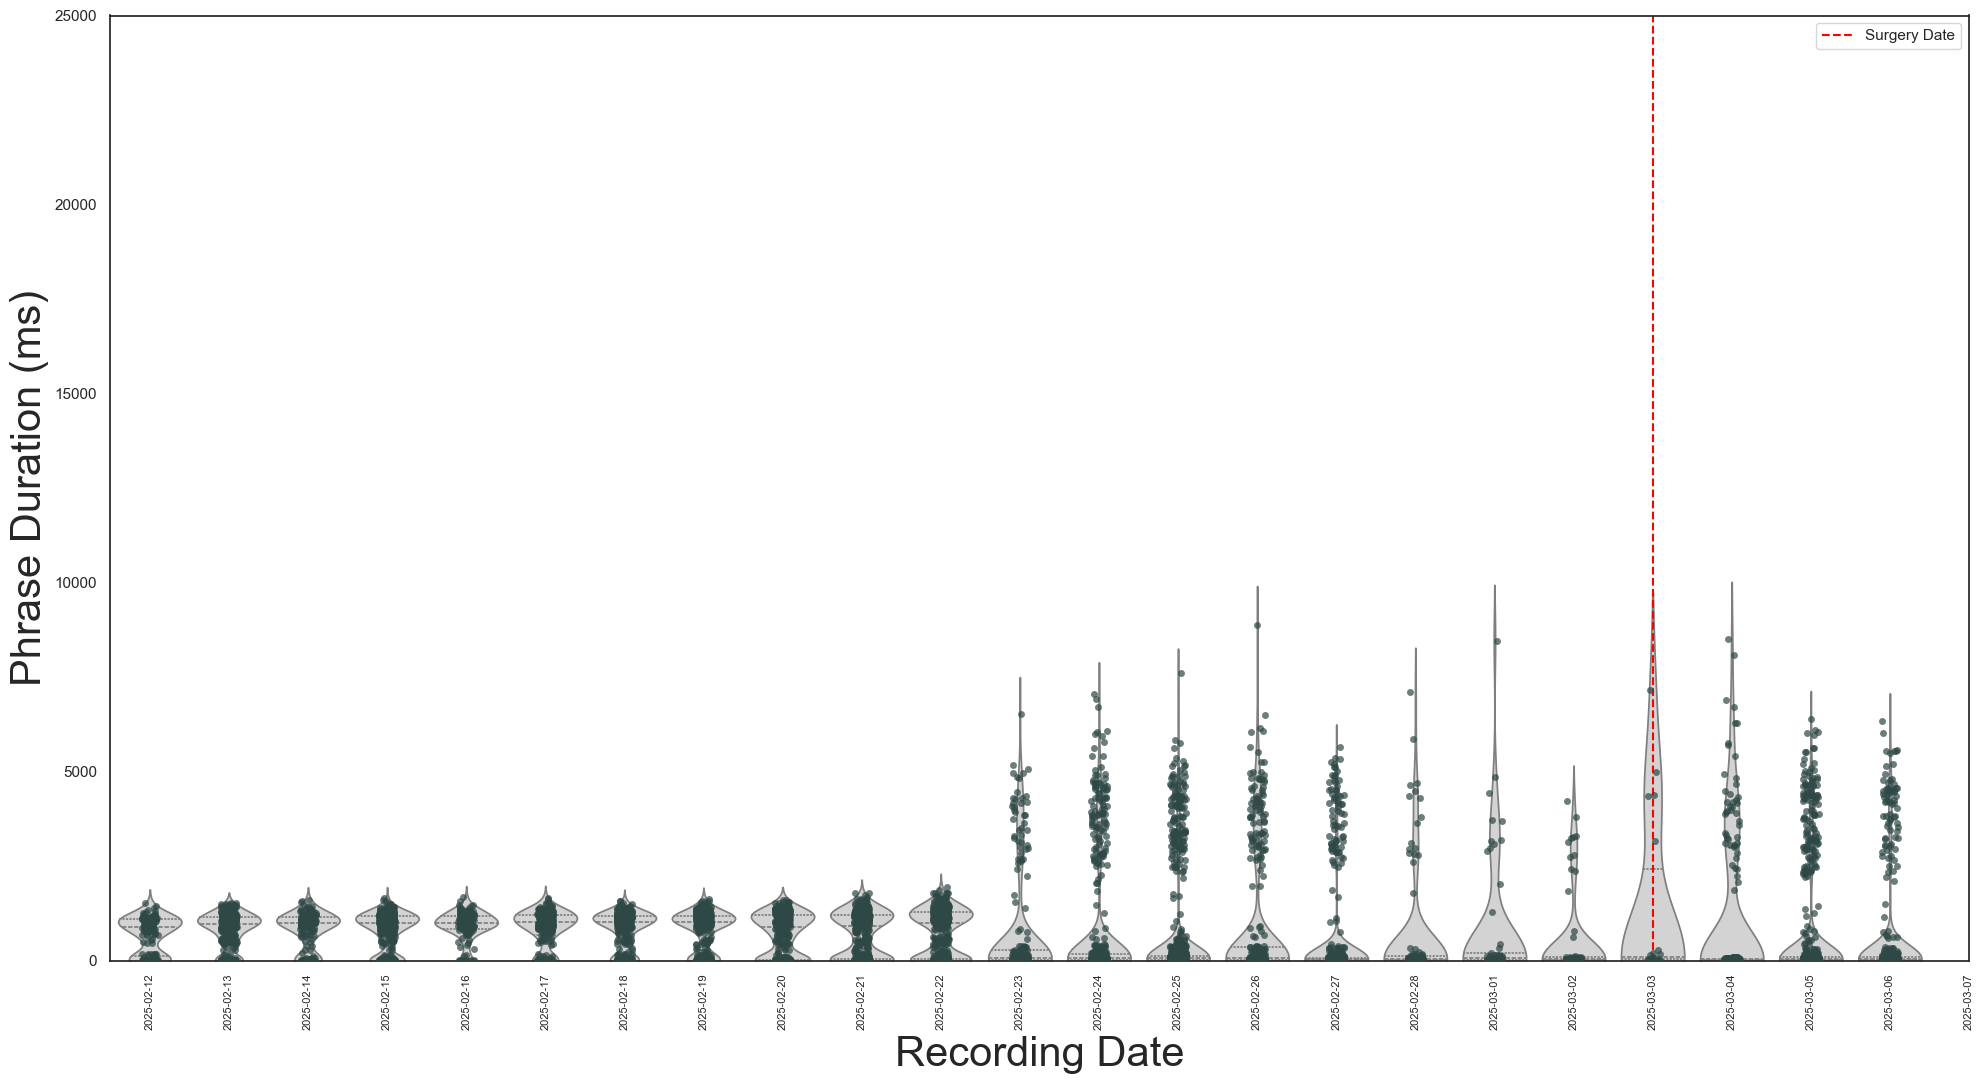

Plot for syllable 8 saved as: /Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/graph_outputs/USA5506_syllable_8_phrase_duration_plot.png


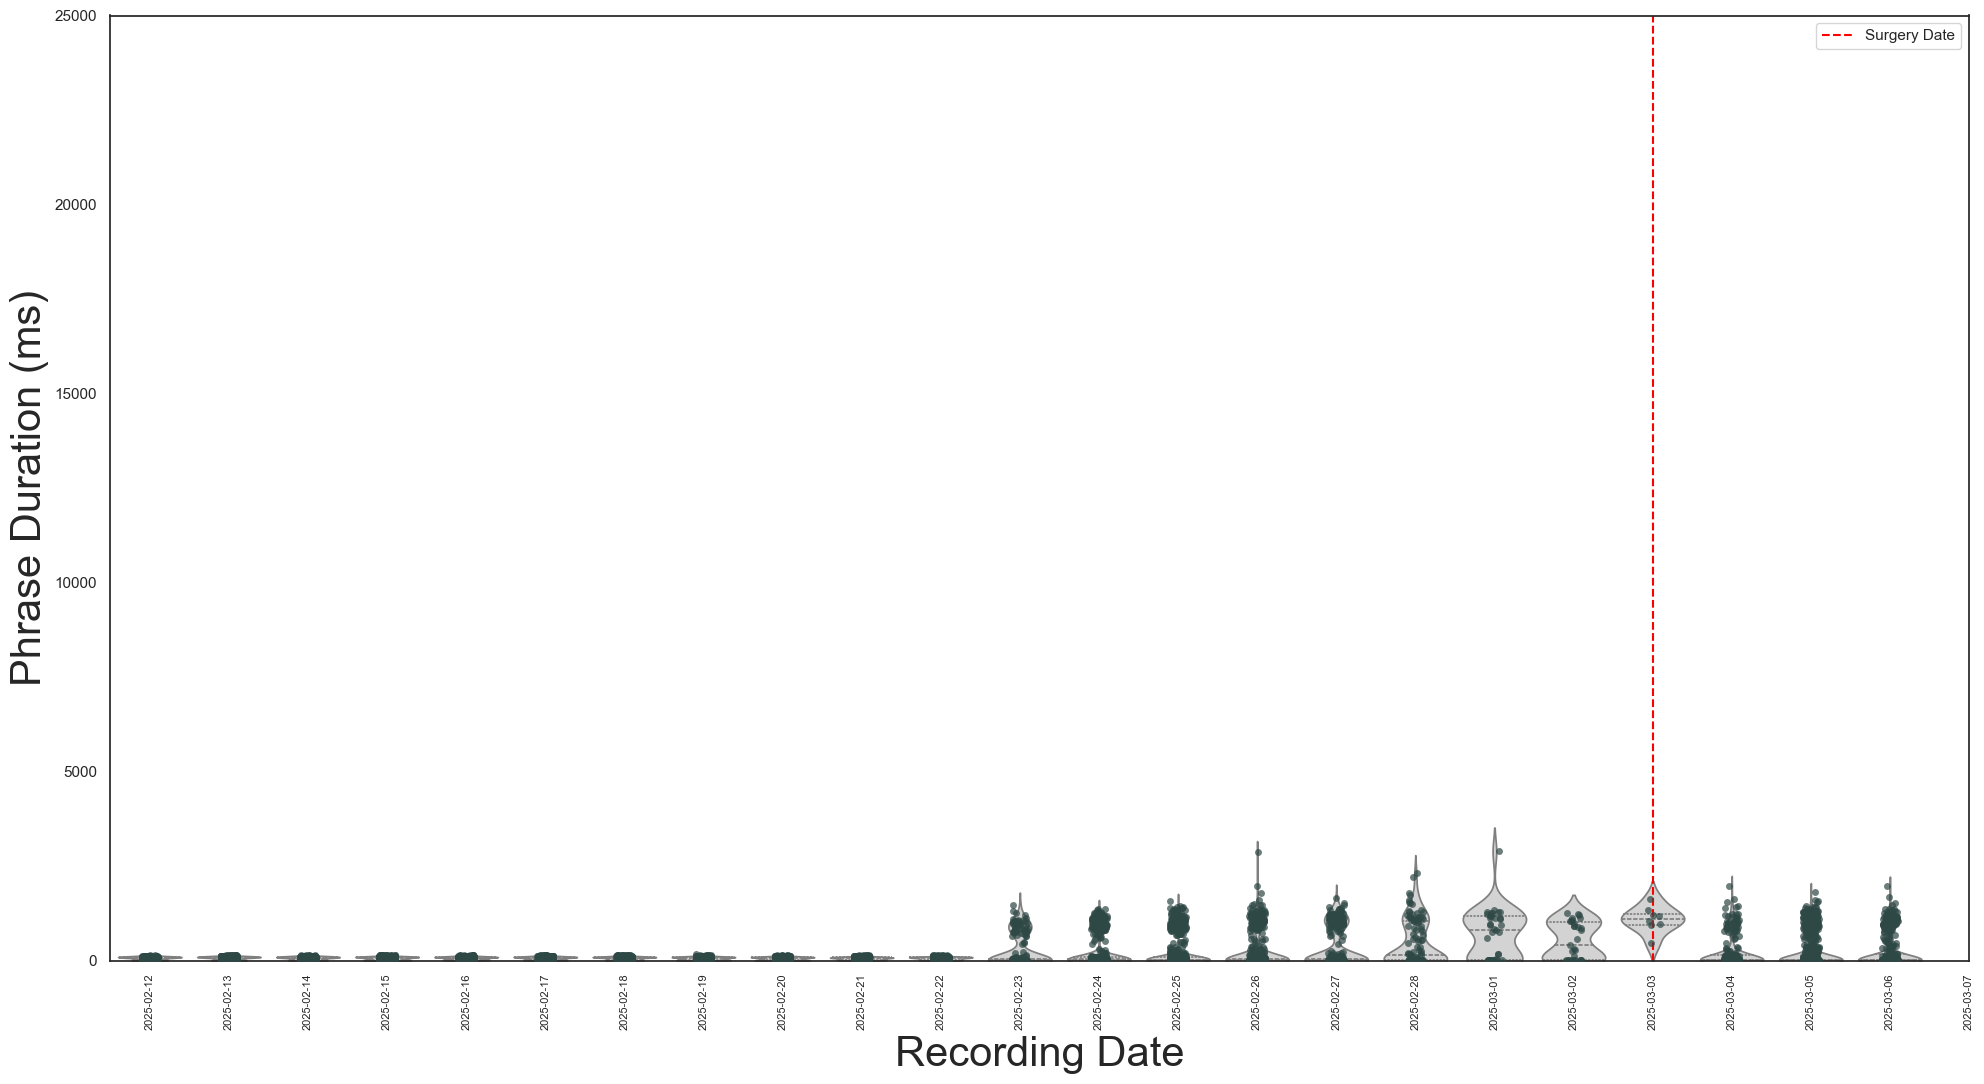

Plot for syllable 17 saved as: /Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/graph_outputs/USA5506_syllable_17_phrase_duration_plot.png


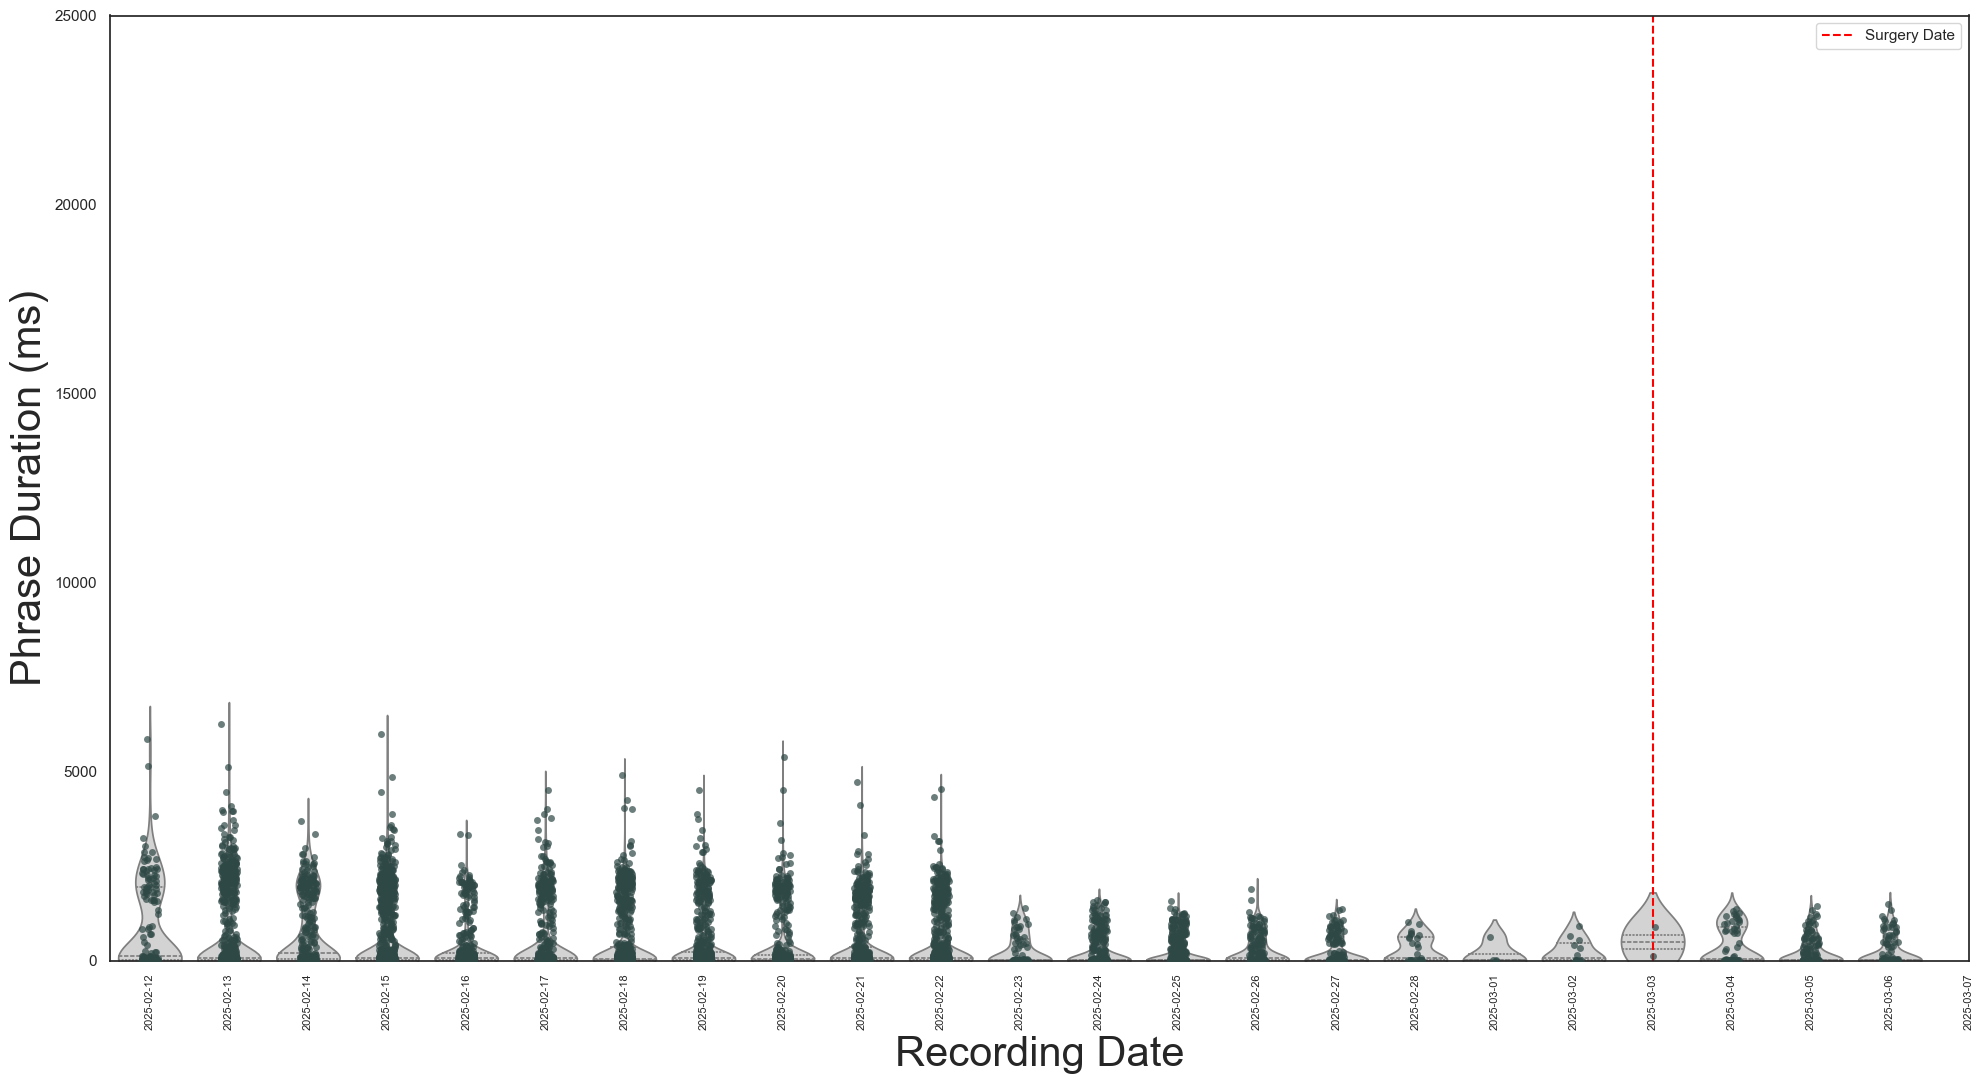

Plot for syllable 4 saved as: /Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/graph_outputs/USA5506_syllable_4_phrase_duration_plot.png


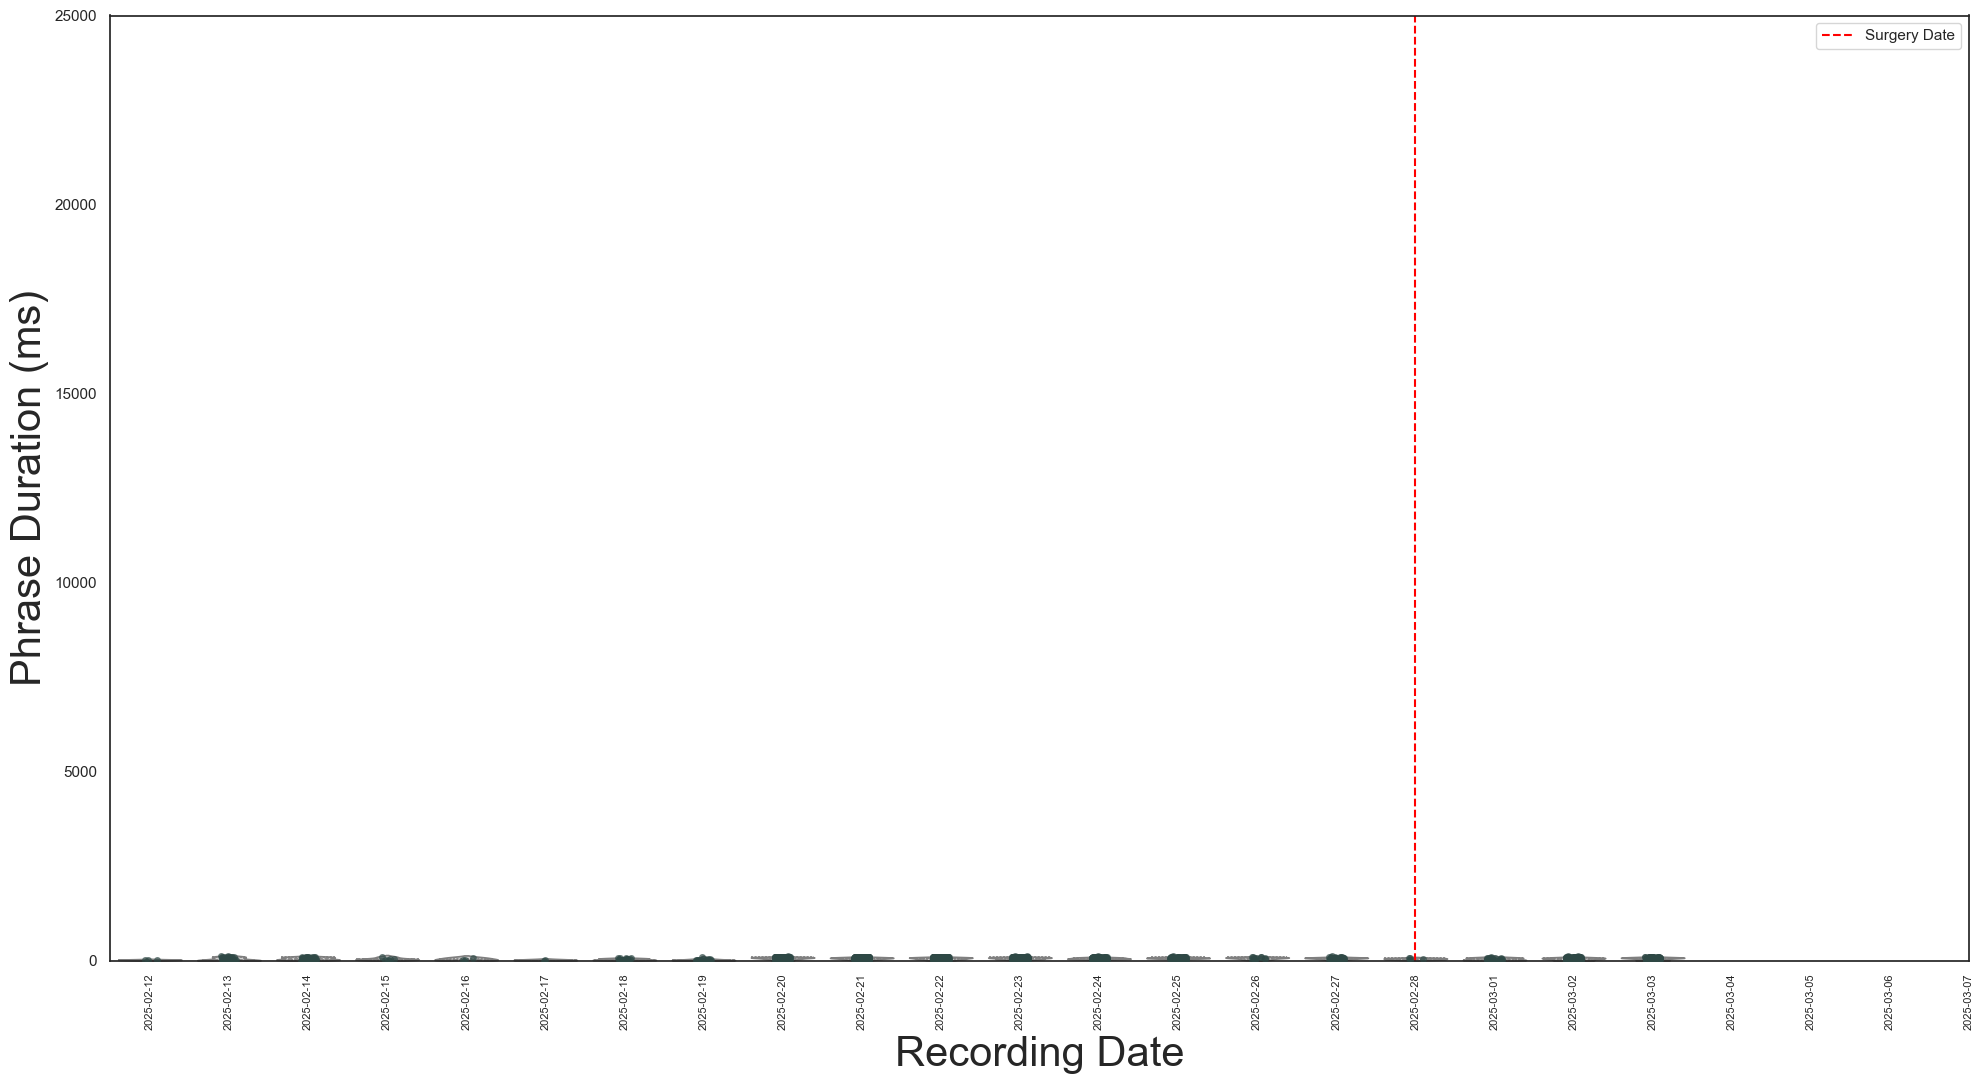

Plot for syllable 14 saved as: /Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/graph_outputs/USA5506_syllable_14_phrase_duration_plot.png


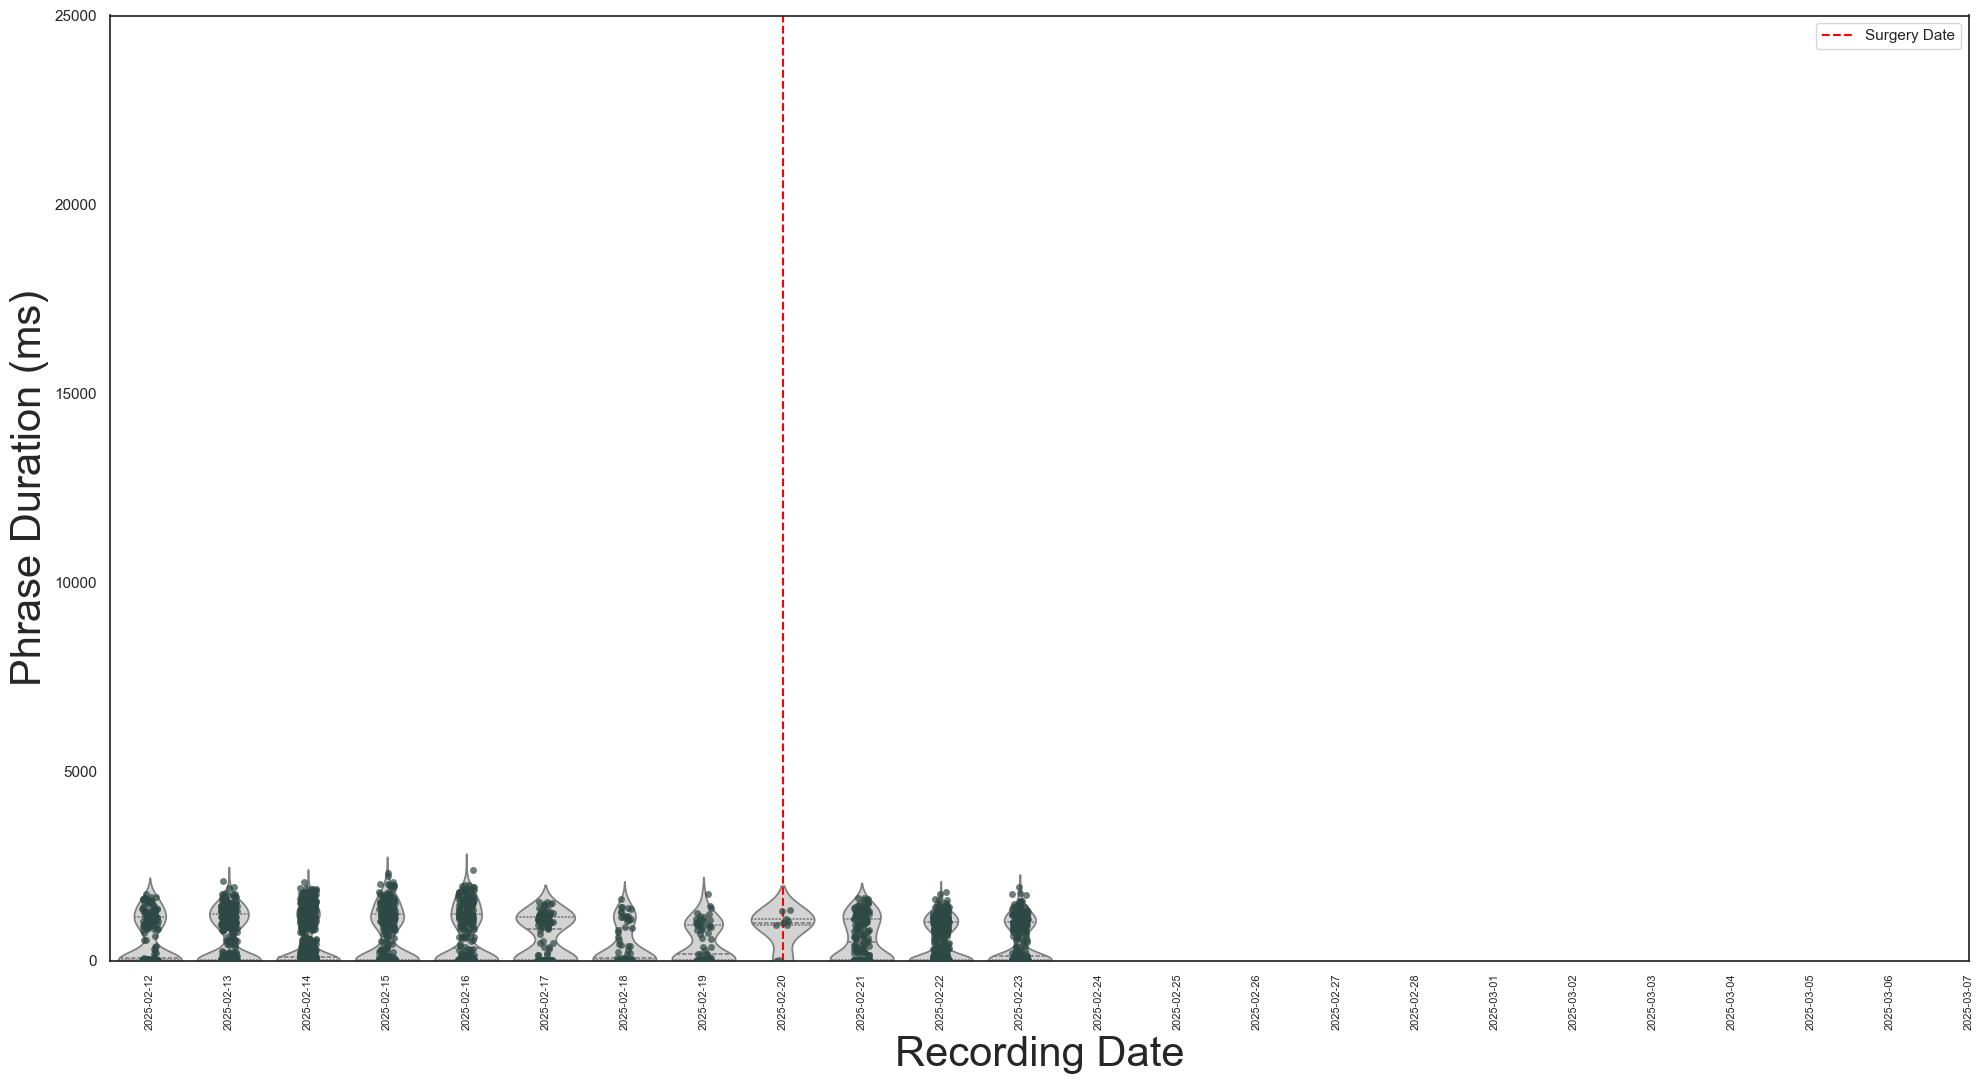

Plot for syllable 7 saved as: /Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/graph_outputs/USA5506_syllable_7_phrase_duration_plot.png


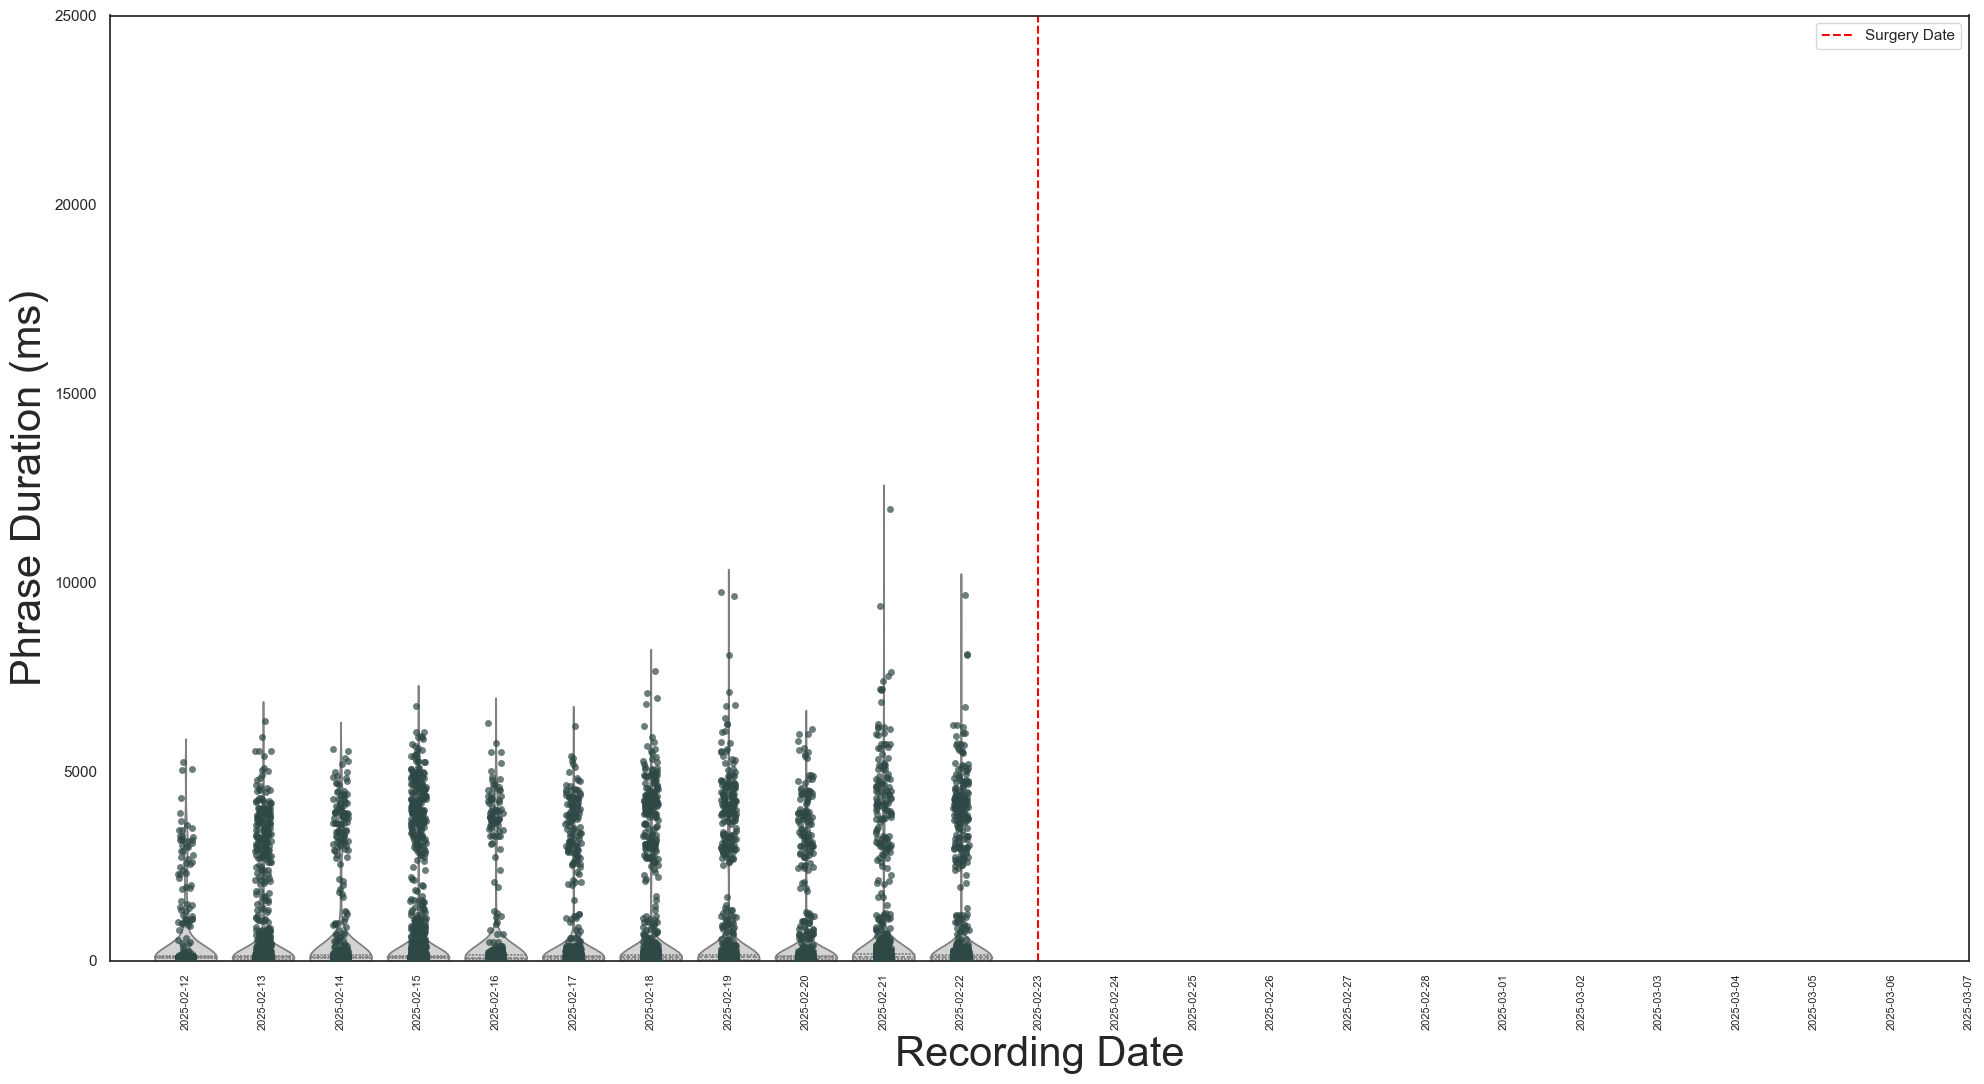

Plot for syllable 1 saved as: /Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/graph_outputs/USA5506_syllable_1_phrase_duration_plot.png


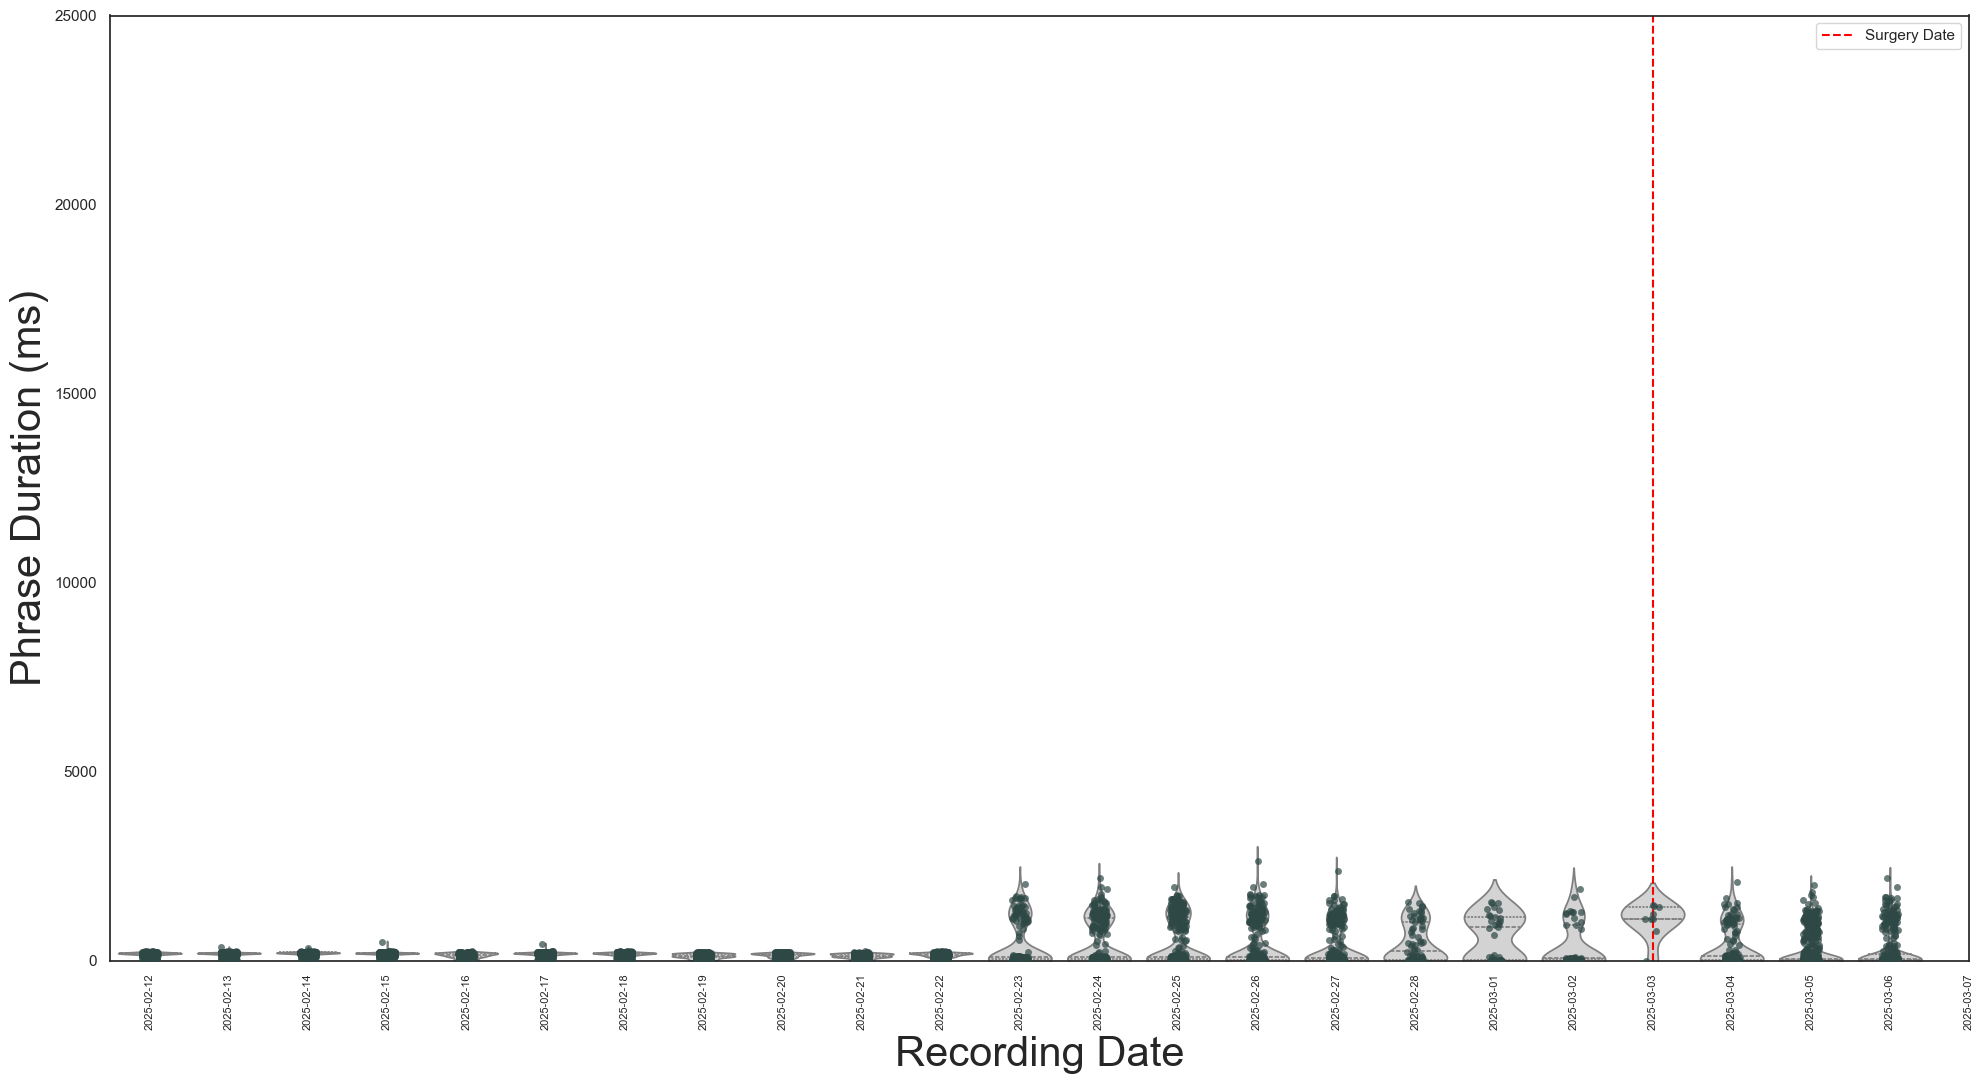

Plot for syllable 13 saved as: /Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/graph_outputs/USA5506_syllable_13_phrase_duration_plot.png


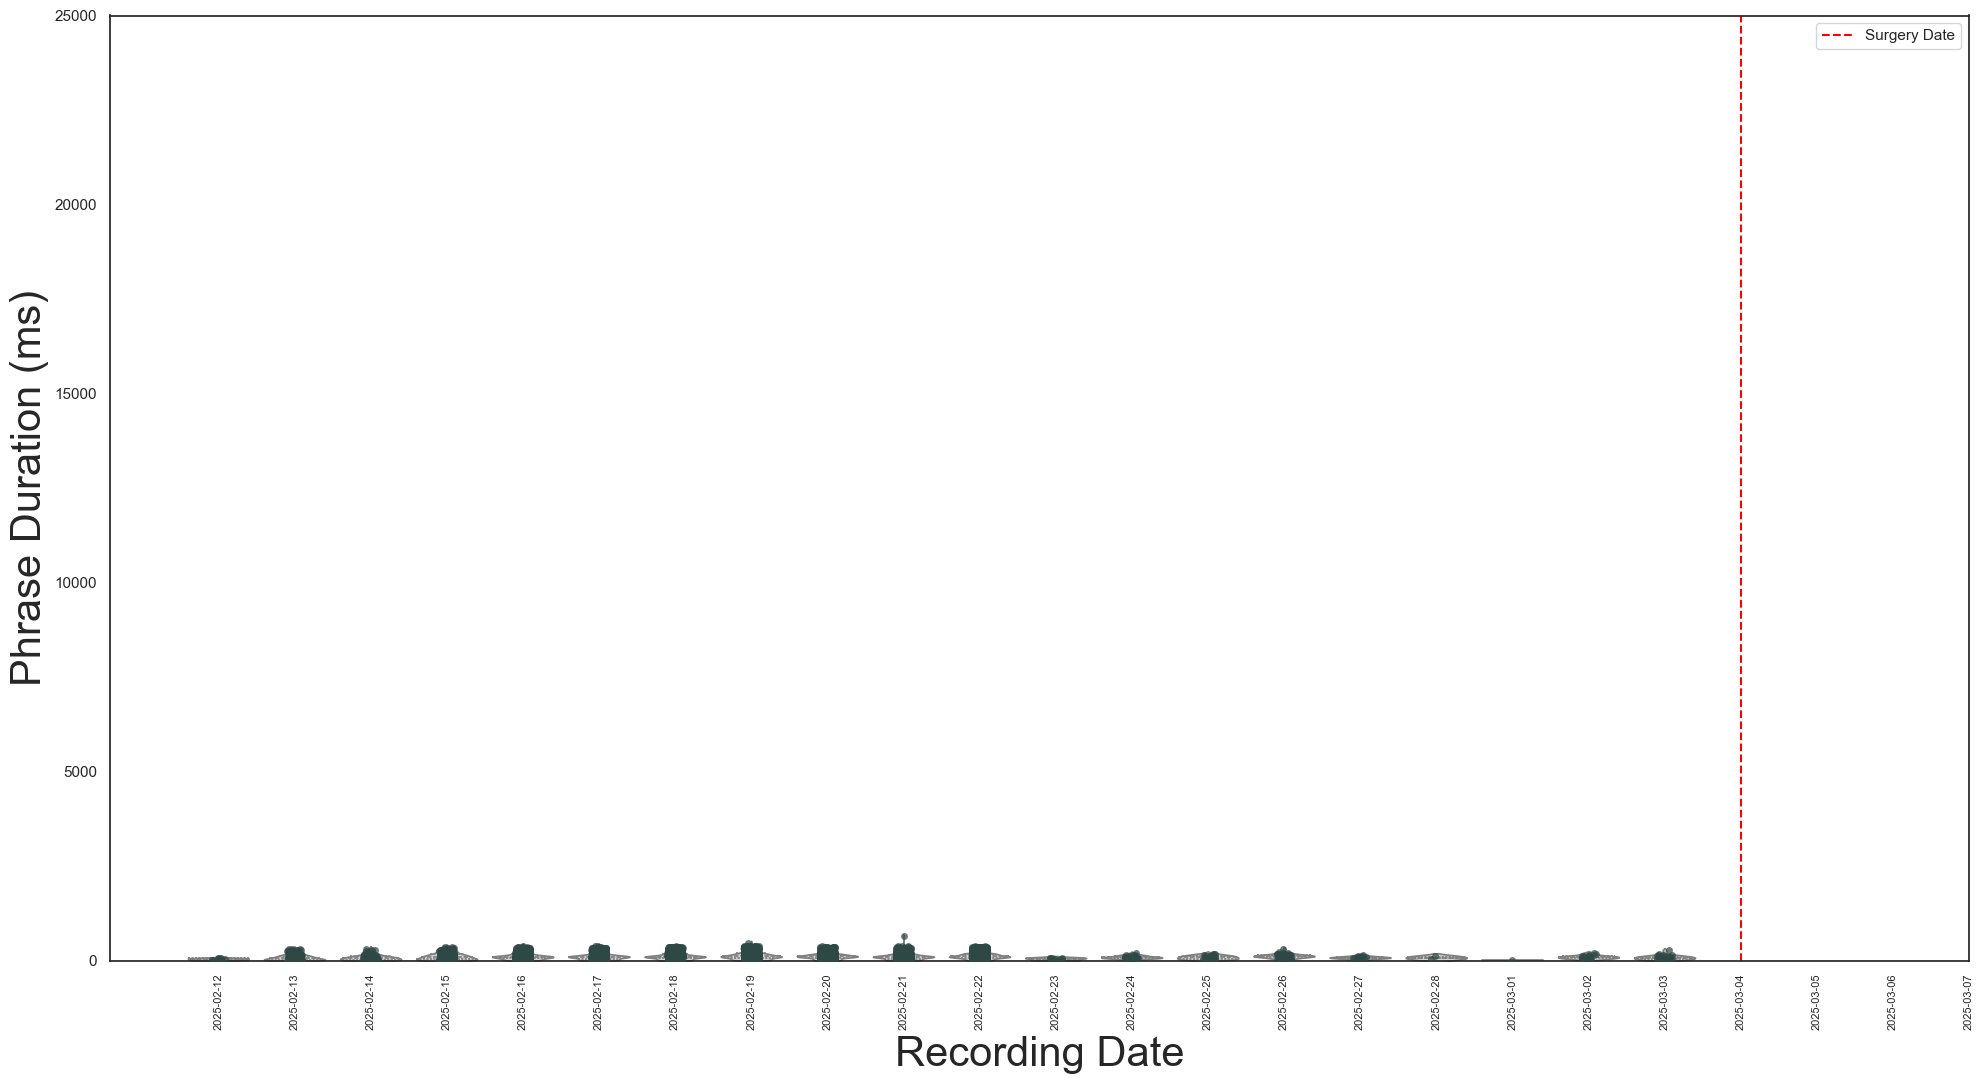

Plot for syllable 11 saved as: /Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/graph_outputs/USA5506_syllable_11_phrase_duration_plot.png


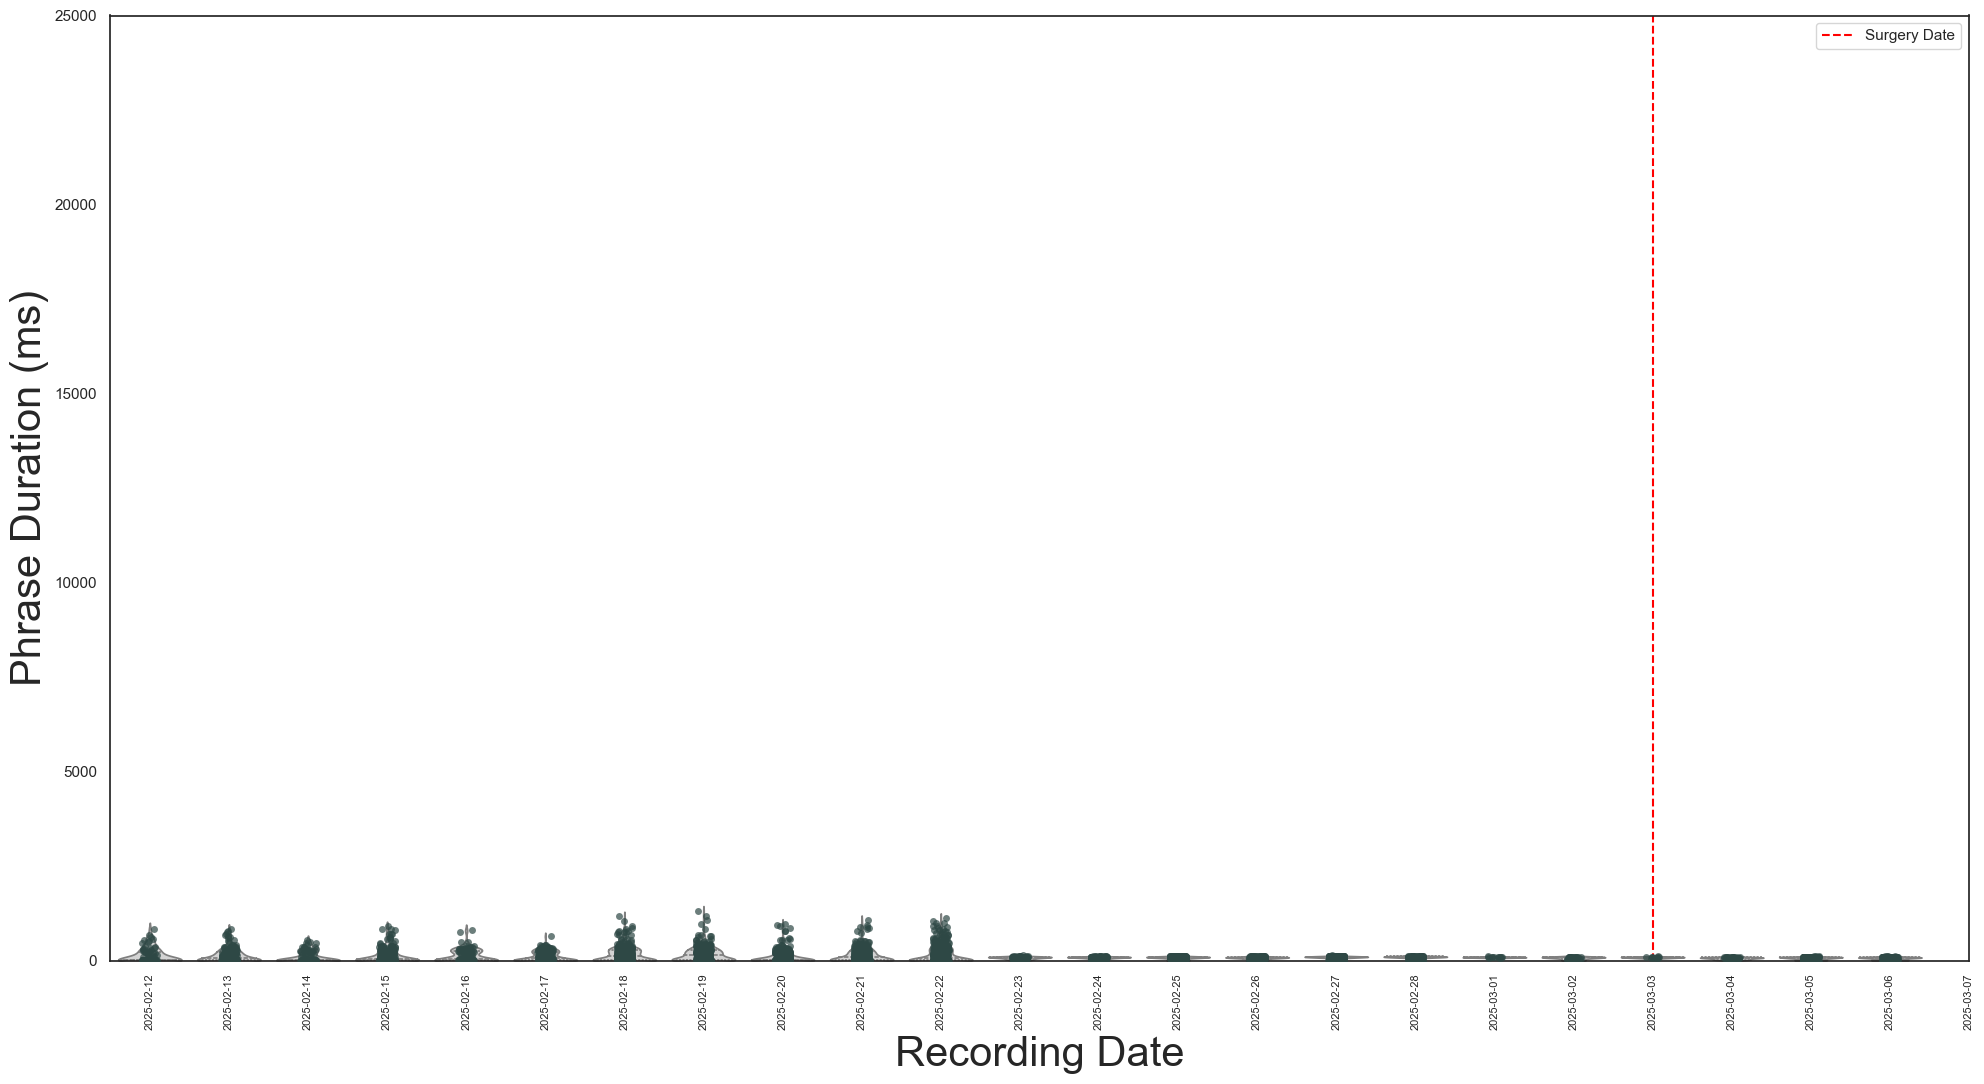

Plot for syllable 9 saved as: /Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/graph_outputs/USA5506_syllable_9_phrase_duration_plot.png


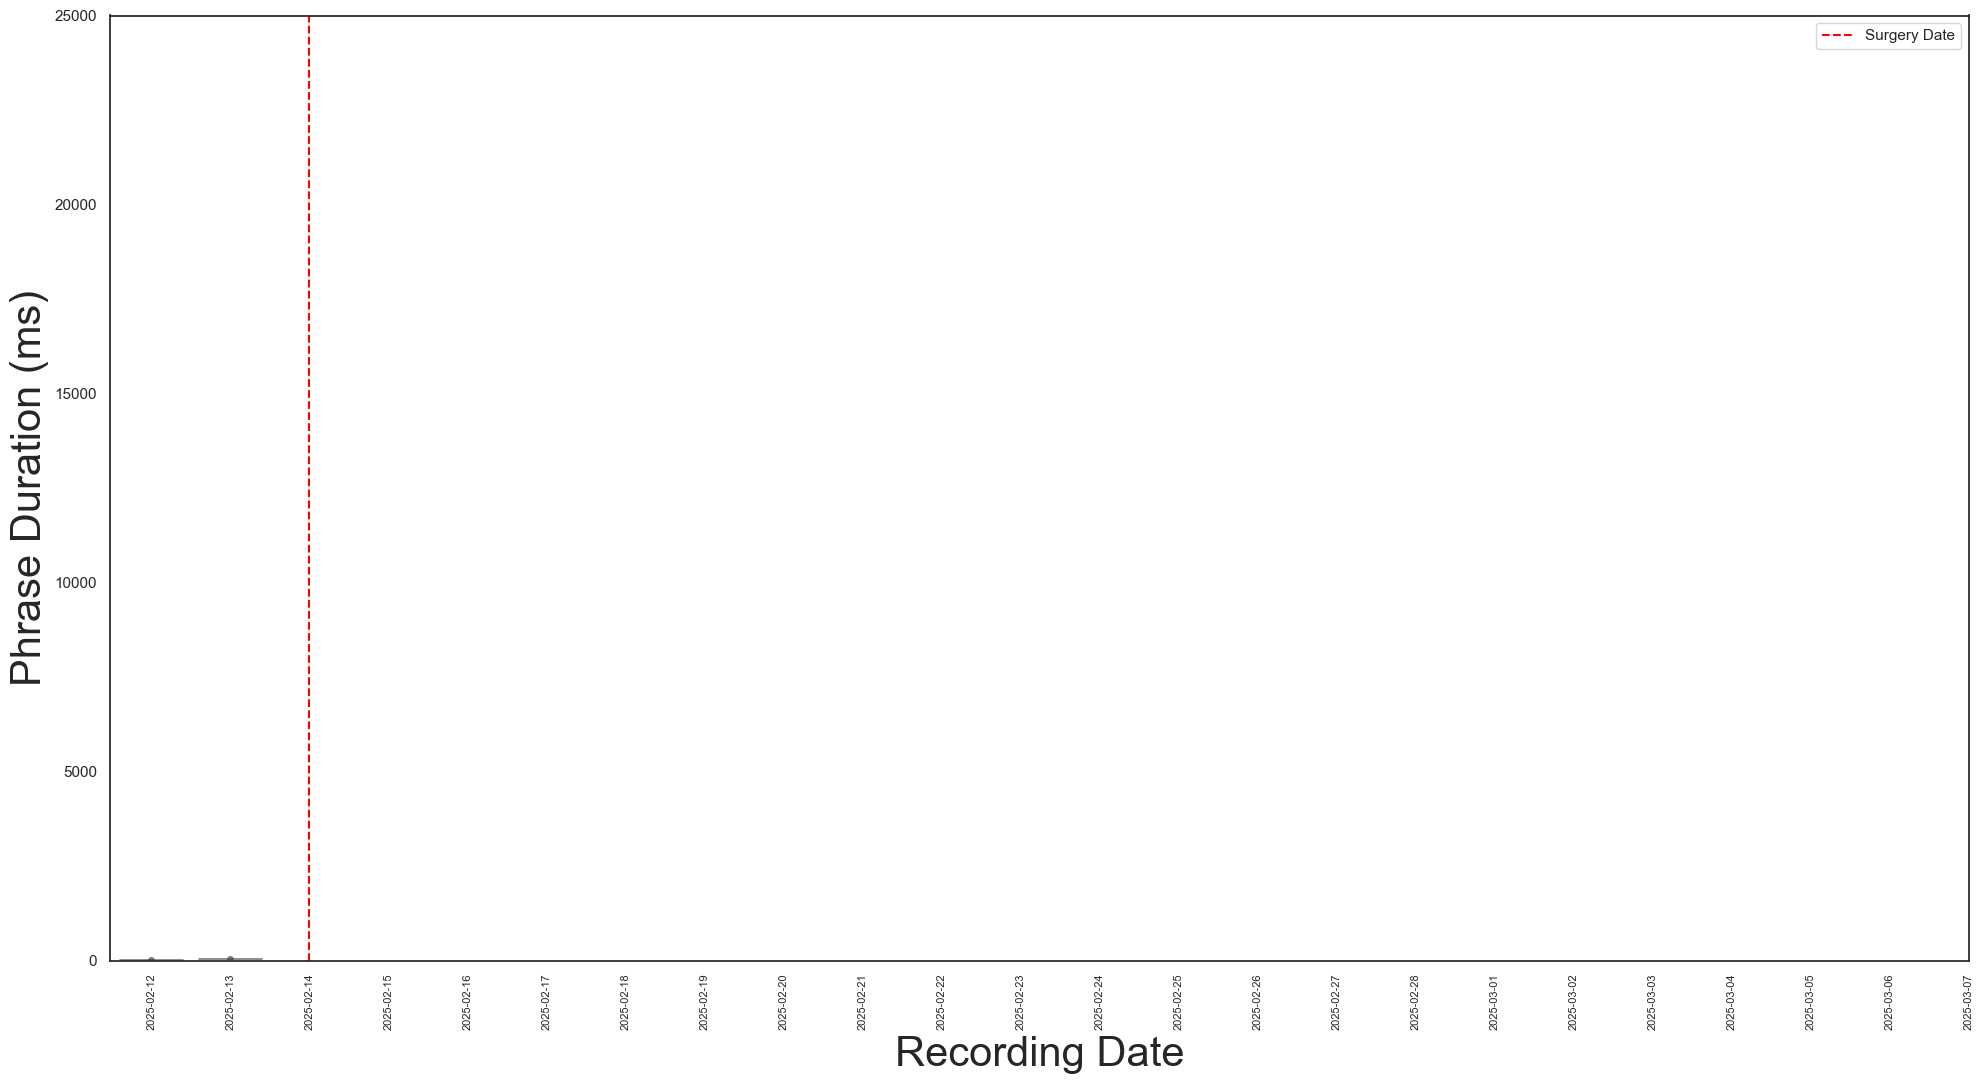

Plot for syllable 12 saved as: /Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/graph_outputs/USA5506_syllable_12_phrase_duration_plot.png


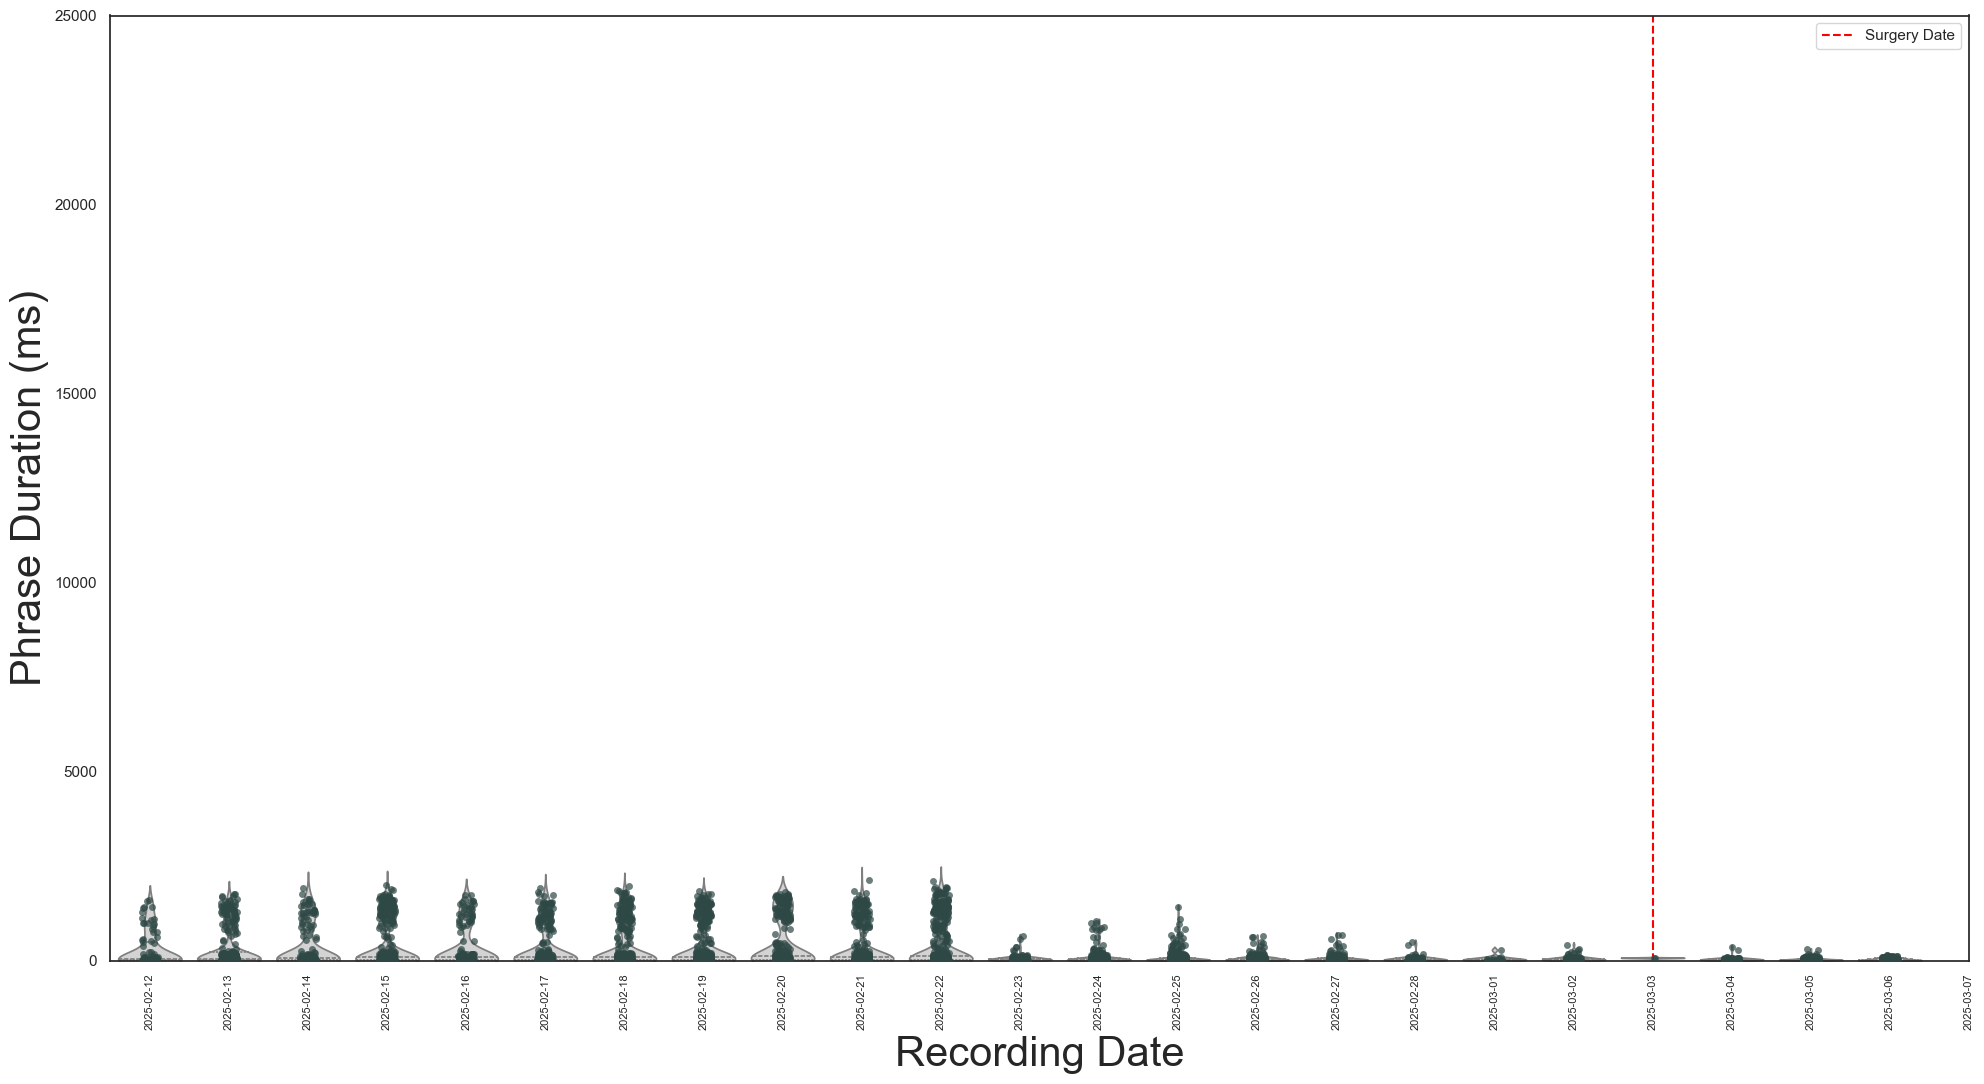

Plot for syllable 3 saved as: /Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/graph_outputs/USA5506_syllable_3_phrase_duration_plot.png


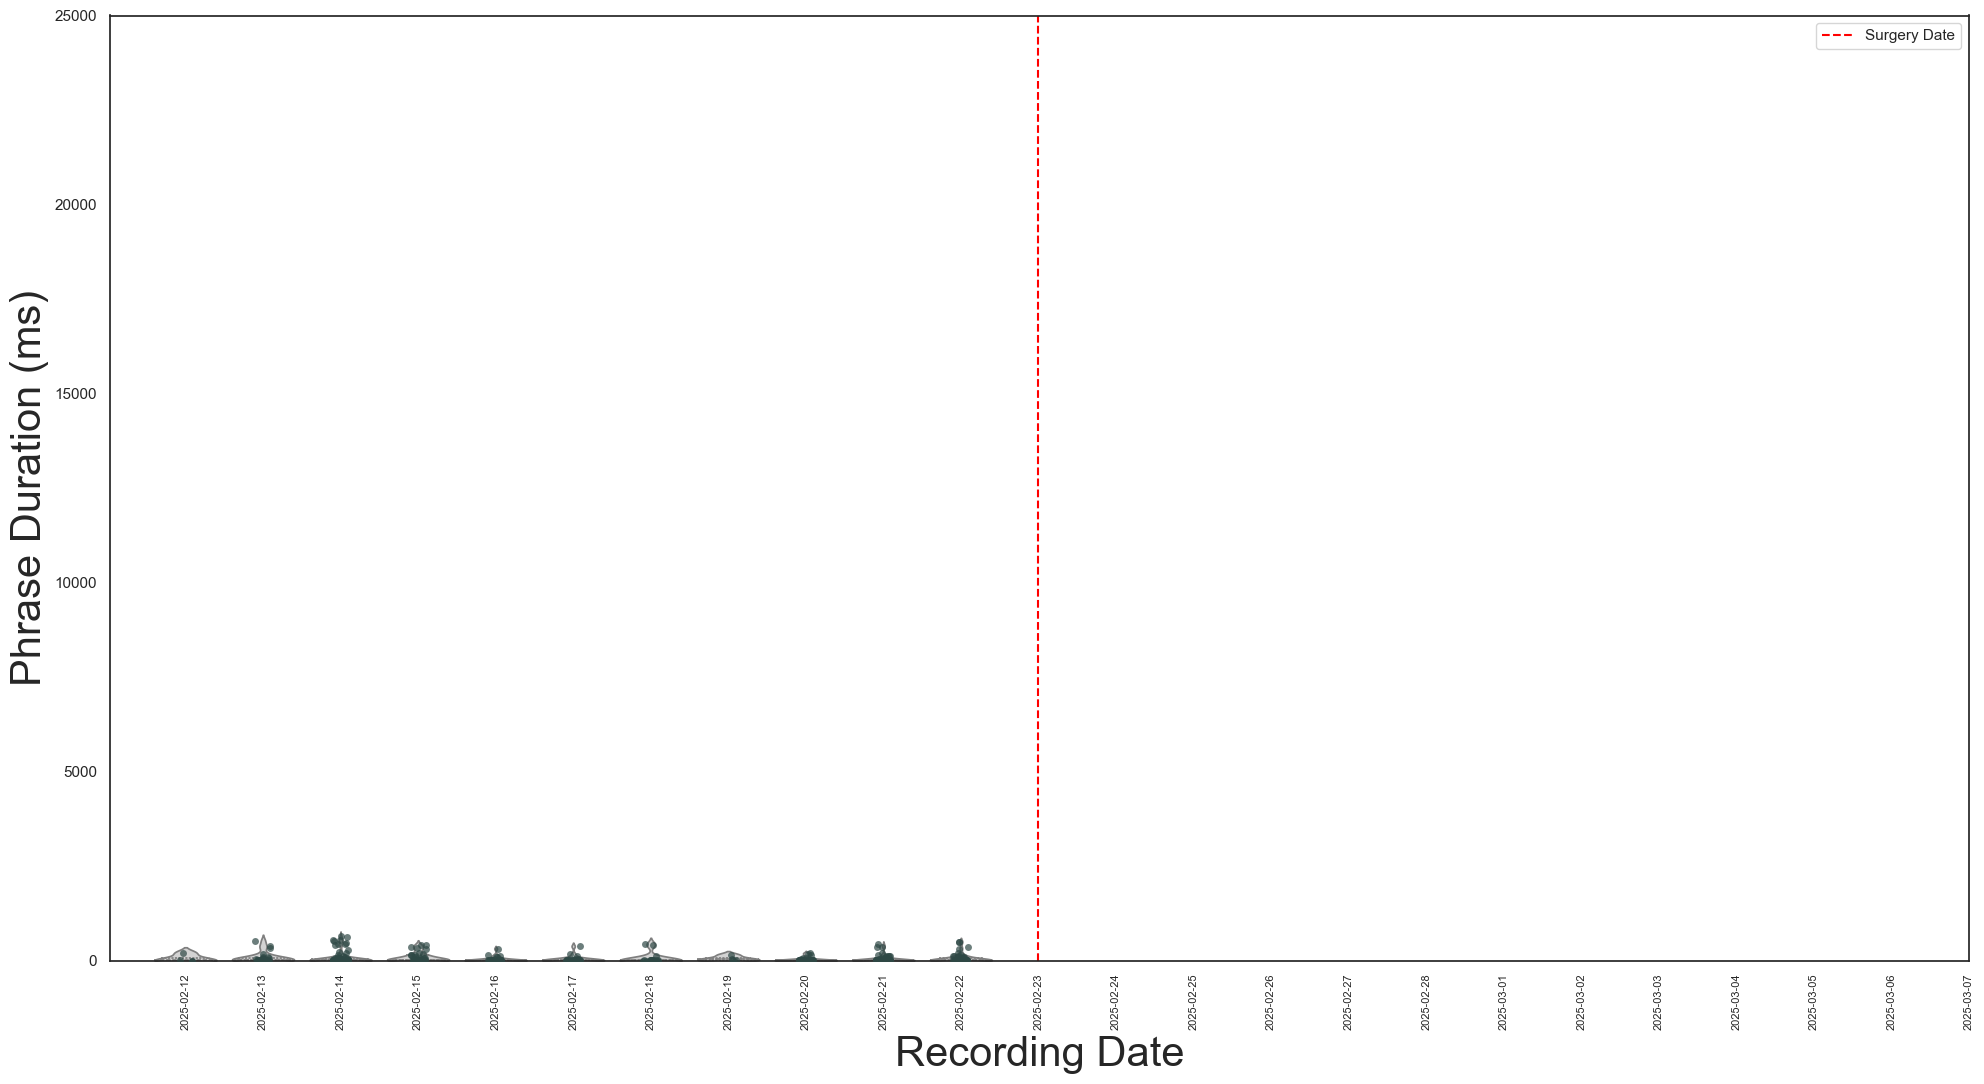

Plot for syllable 0 saved as: /Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/graph_outputs/USA5506_syllable_0_phrase_duration_plot.png


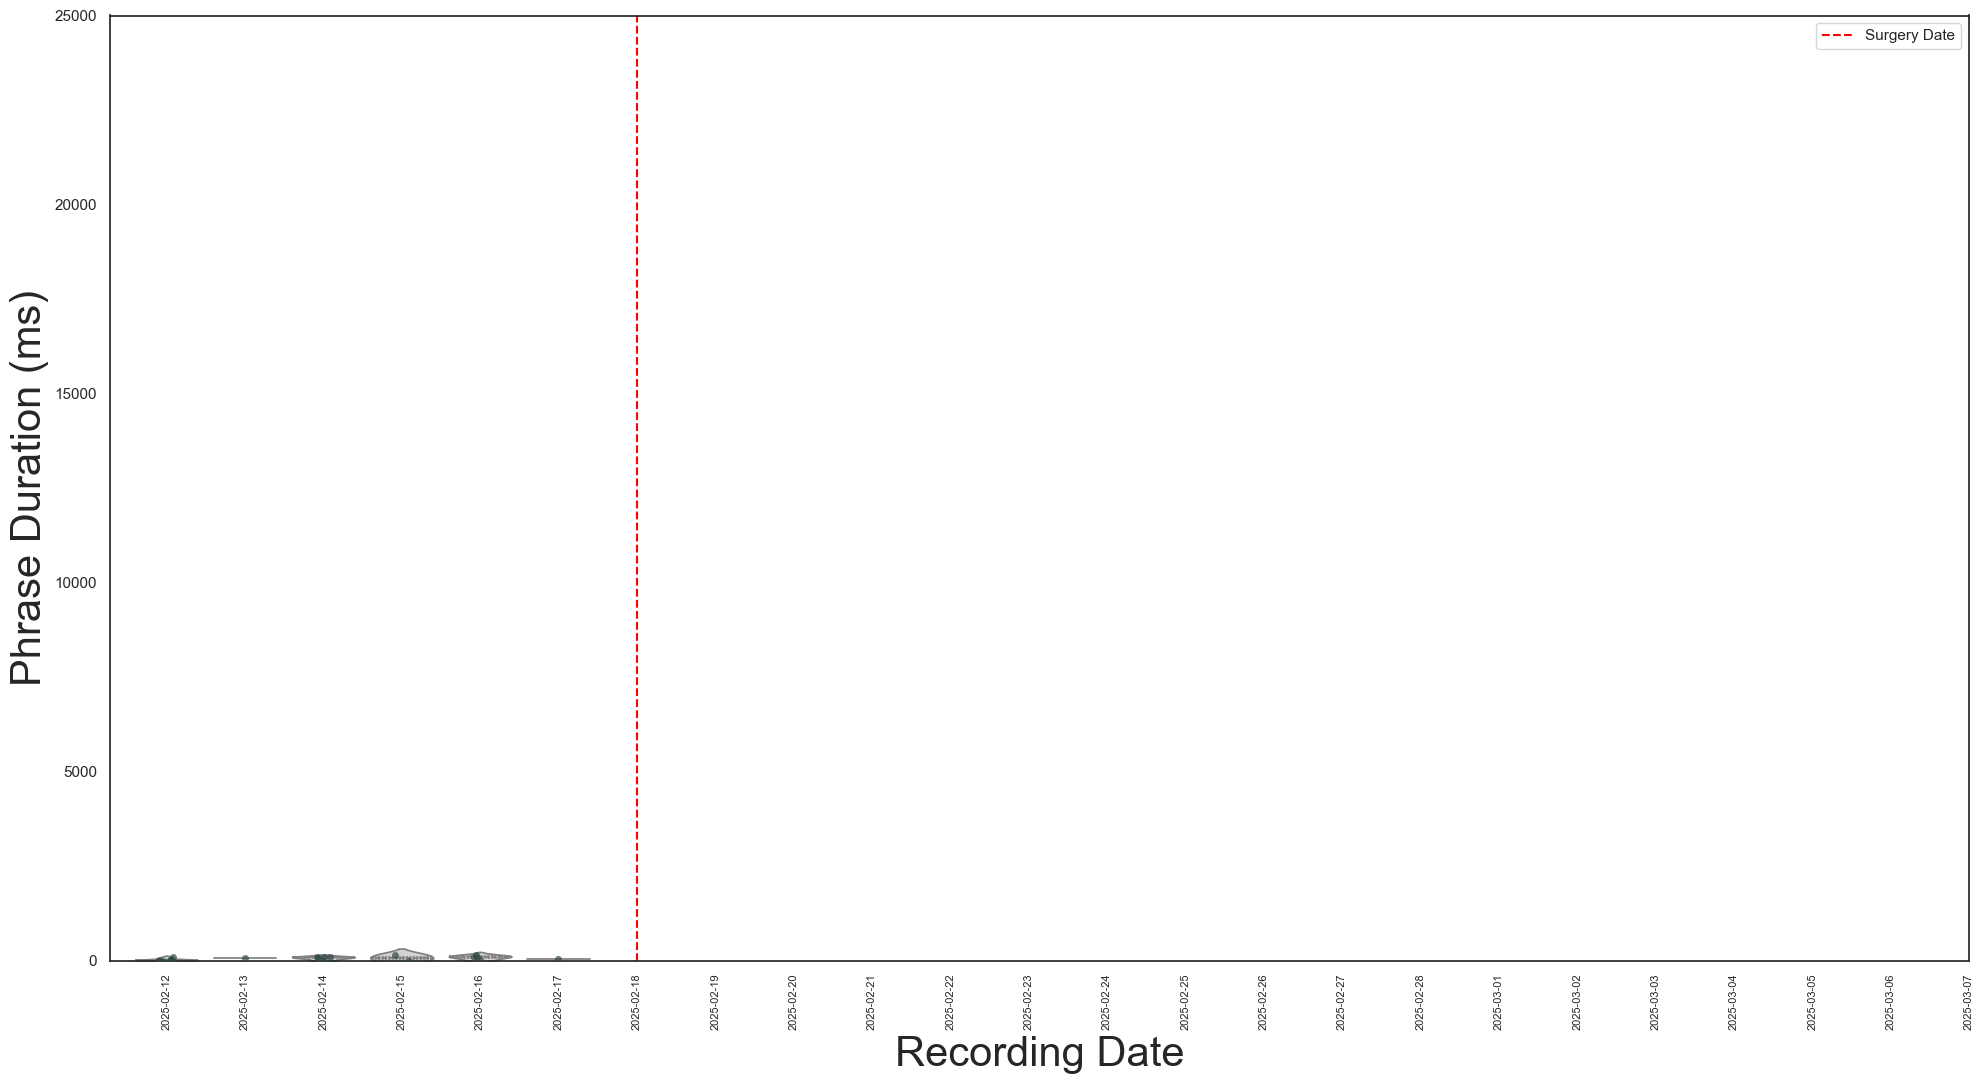

Plot for syllable 10 saved as: /Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/graph_outputs/USA5506_syllable_10_phrase_duration_plot.png


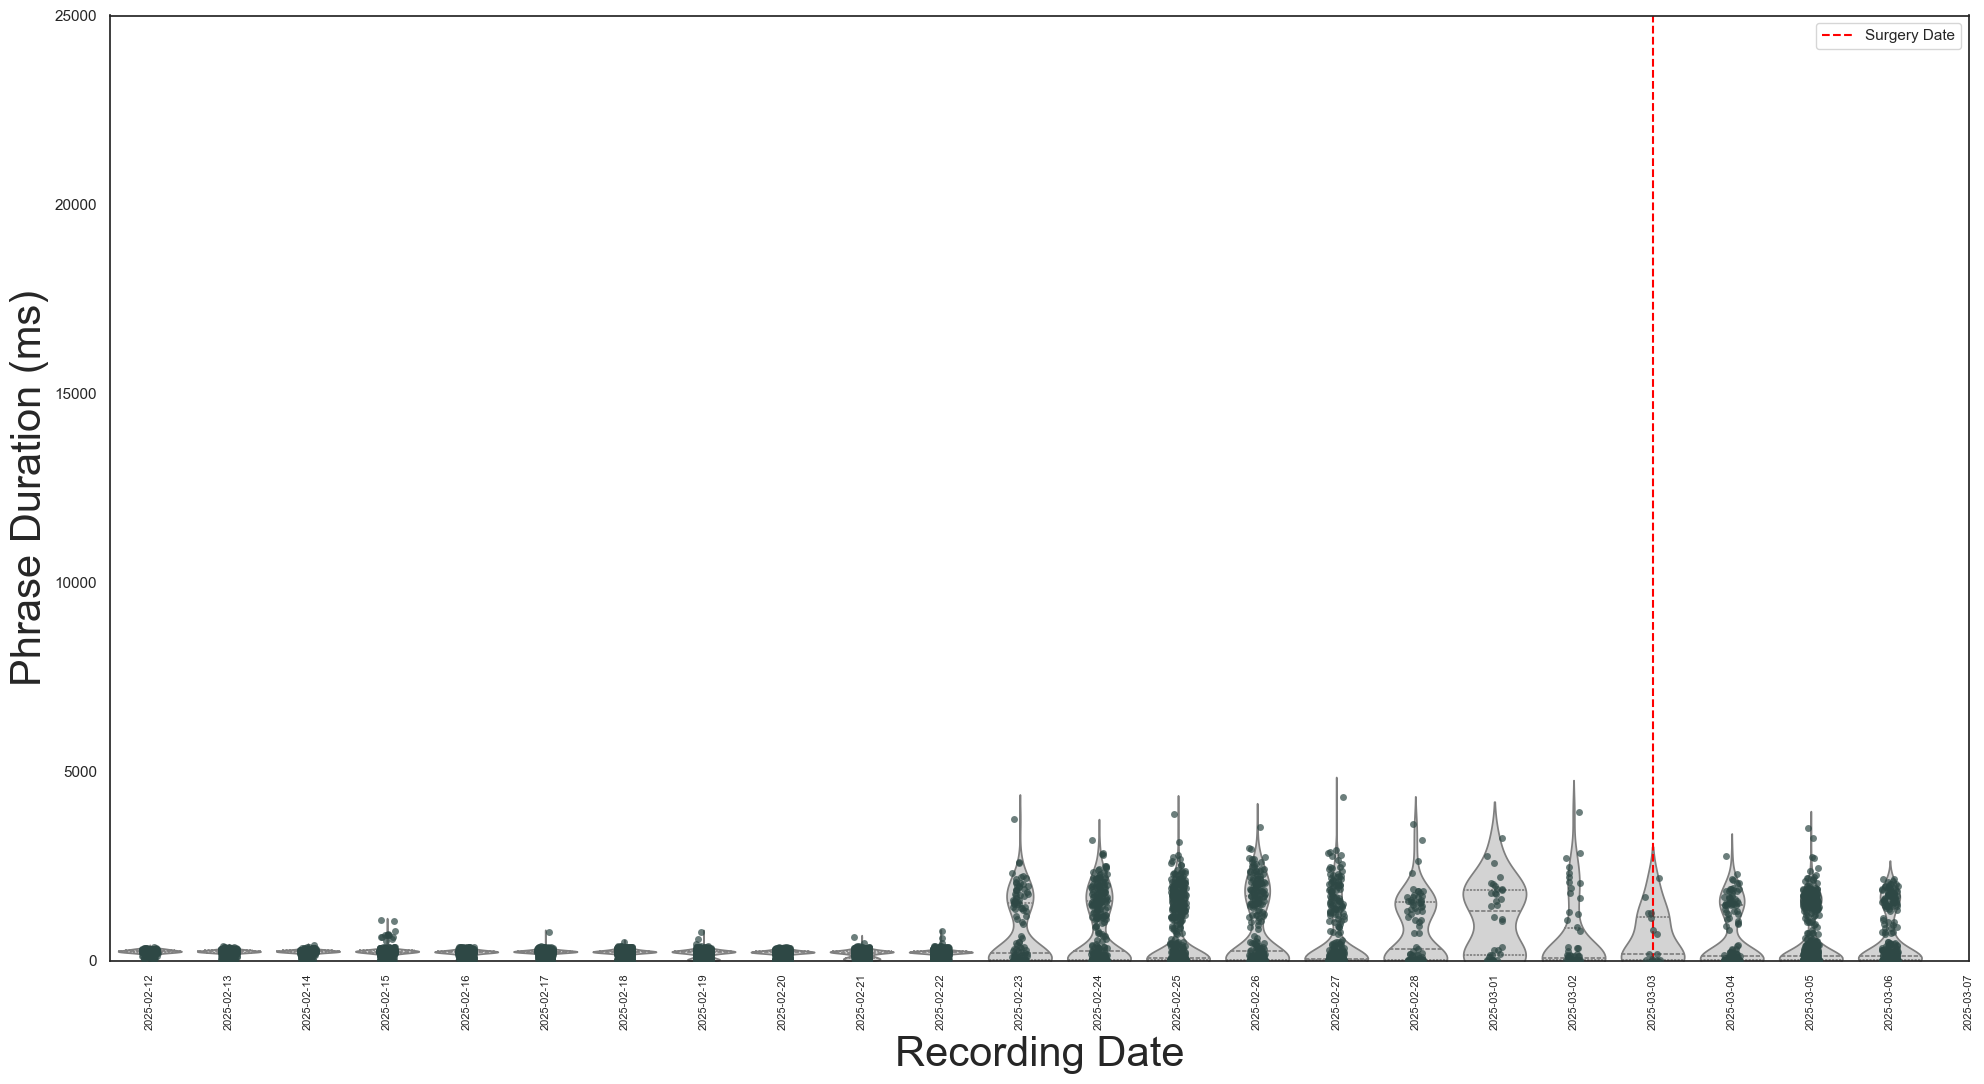

Plot for syllable 16 saved as: /Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/graph_outputs/USA5506_syllable_16_phrase_duration_plot.png


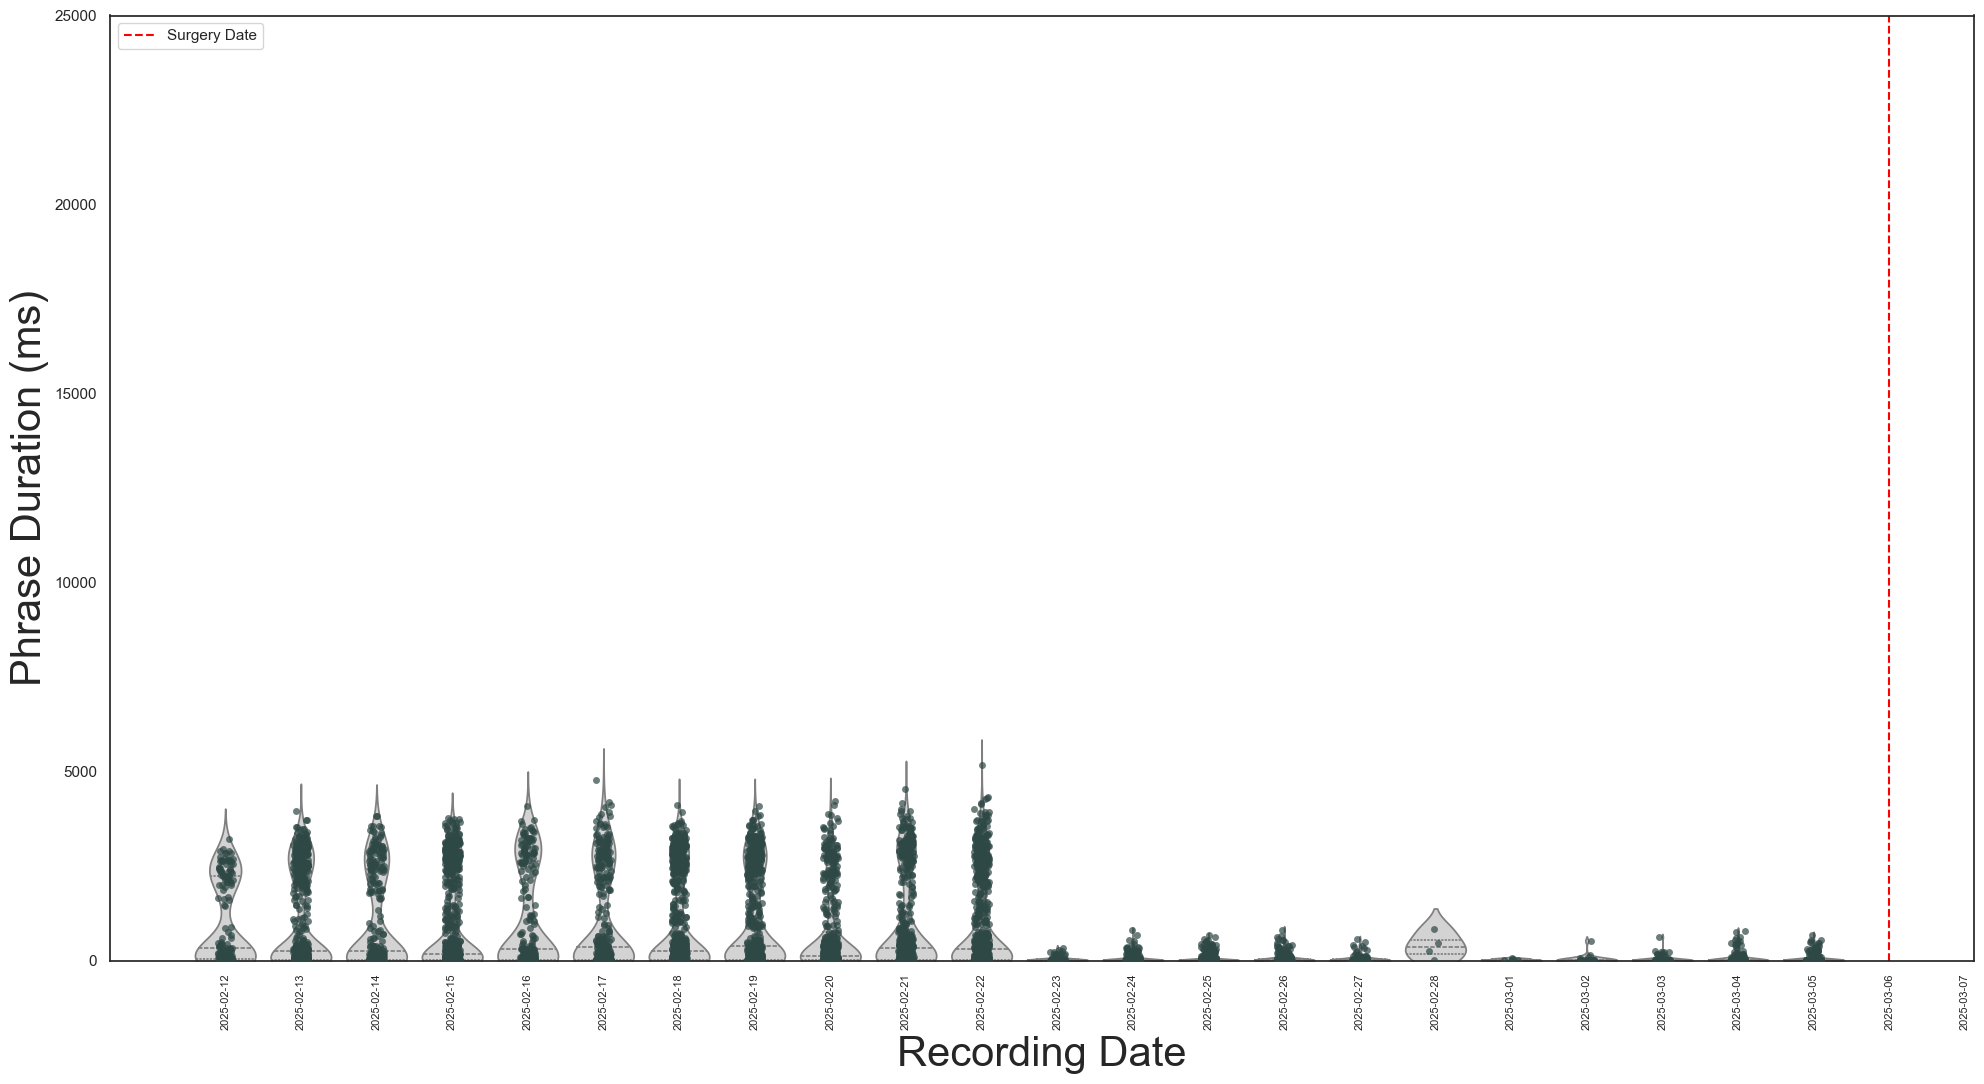

Plot for syllable 6 saved as: /Volumes/ROSE2-SSD/RHV_song_counts/RC1_USA5506_Comp2_tweetybert_outputs/graph_outputs/USA5506_syllable_6_phrase_duration_plot.png


In [11]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates

# Ensure the Date column is in datetime format
organized_data_frame['Date'] = pd.to_datetime(organized_data_frame['Date'])

# Get the earliest and latest dates in the DataFrame
earliest_date = organized_data_frame['Date'].min()
latest_date = organized_data_frame['Date'].max()

# Generate a full list of all dates between the earliest and latest recording date
full_date_range = pd.date_range(start=earliest_date, end=latest_date)

# Ensure the surgery date is in datetime format
surgery_date_dt = pd.to_datetime(surgery_date, format='%Y.%m.%d')

# Convert surgery date to string in the same format as the x-axis (YYYY-MM-DD)
surgery_date_str = surgery_date_dt.strftime('%Y-%m-%d')

# Iterate over each syllable label in the unique_syllable_labels array
for syllable_label in unique_syllable_labels:
    # Prepare the column name for the current syllable label (assuming the column format is 'syllable_{label}_durations')
    column_name = f'syllable_{syllable_label}_durations'
    
    # Prepare the data for plotting by exploding the column into individual rows
    exploded_data = organized_data_frame[['Date', column_name]].explode(column_name)
    
    # Convert durations to numeric, handle errors, and drop missing values
    exploded_data[column_name] = pd.to_numeric(exploded_data[column_name], errors='coerce')
    exploded_data = exploded_data.dropna(subset=[column_name])

    # Set up the plotting environment (no gridlines)
    plt.figure(figsize=(20, 11))
    sns.set(style="white")  # Removes the gridlines

    # Initialize the plot
    for current_date in full_date_range:
        # Filter the data for the current date
        daily_data = exploded_data[exploded_data['Date'] == current_date]

        # If there is no data for the current date, skip to the next date
        if daily_data.empty:
            continue

        # Create a violin plot for the current day with updated `density_norm`
        sns.violinplot(x='Date', y=column_name, data=daily_data, inner="quartile", density_norm="width", color="lightgray")

        # Overlay a scatter plot (strip plot) with jitter for better visibility of individual points
        sns.stripplot(x='Date', y=column_name, data=daily_data, jitter=True, size=5, color="#2E4845", alpha=0.7)  # Hunter green color

    # Set the y-axis limit from 0 to 40,000 ms
    plt.ylim(0, 25000)

    # Add a dashed red vertical line at the surgery date (in string format)
    plt.axvline(x=surgery_date_str, color='red', linestyle='--', label='Surgery Date')

    # Customize the plot
    animal_id = organized_data_frame['Animal ID'].iloc[0]
    #plt.title(f'Distribution of Syllable {syllable_label} Phrase Durations Across Recording Dates\nAnimal ID: {animal_id}', fontsize=18)
    plt.xlabel('Recording Date', fontsize=30)
    plt.ylabel('Phrase Duration (ms)', fontsize=30)
    plt.xticks(ticks=range(len(full_date_range)), labels=[date.strftime('%Y-%m-%d') for date in full_date_range], rotation=90, fontsize = 8)

    # Add a legend to indicate the surgery date line
    plt.legend()

    # Ensure the directory exists
    os.makedirs(save_output_to_this_file_path, exist_ok=True)

    # Save the figure as a PNG file, including the syllable label and animal ID in the file name
    output_file_name = f"{save_output_to_this_file_path}/{animal_id}_syllable_{syllable_label}_phrase_duration_plot.png"
    plt.savefig(output_file_name, format='png', dpi=300, transparent=True)

    # Display the plot
    plt.tight_layout()
    plt.show()

    # Confirm file was saved
    print(f"Plot for syllable {syllable_label} saved as: {output_file_name}")

## Phrase durations for early pre-lesion, late pre-lesion, post-lesion:

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_28492/1127871989.py:31: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Syllable', y='Phrase Duration (ms)', data=plot_data, inner="quartile", scale="width", color="lightgray")


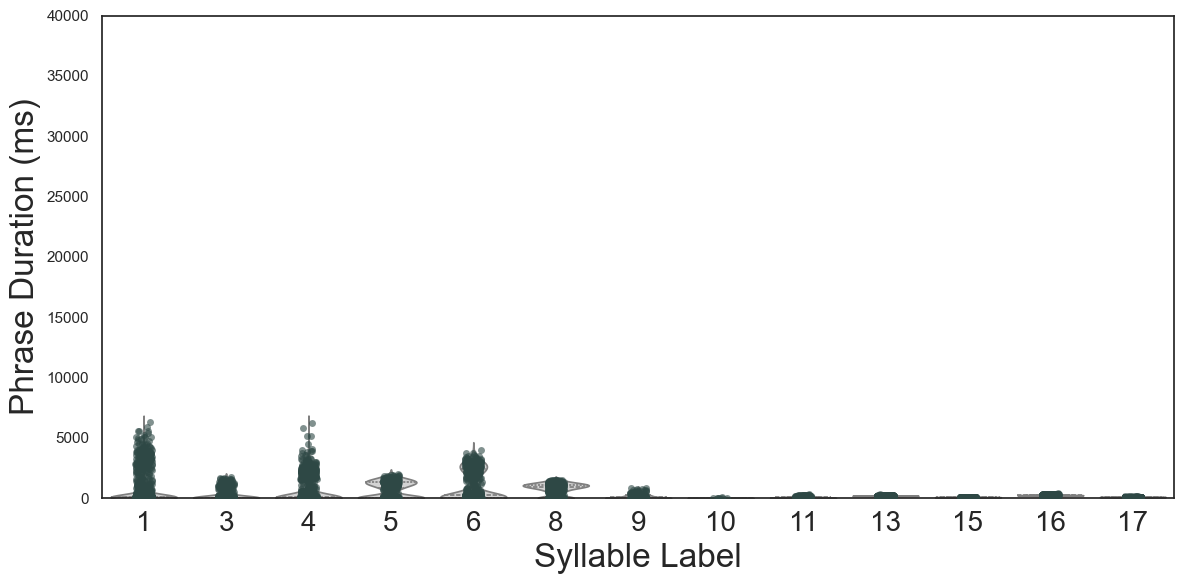

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_28492/1127871989.py:31: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Syllable', y='Phrase Duration (ms)', data=plot_data, inner="quartile", scale="width", color="lightgray")


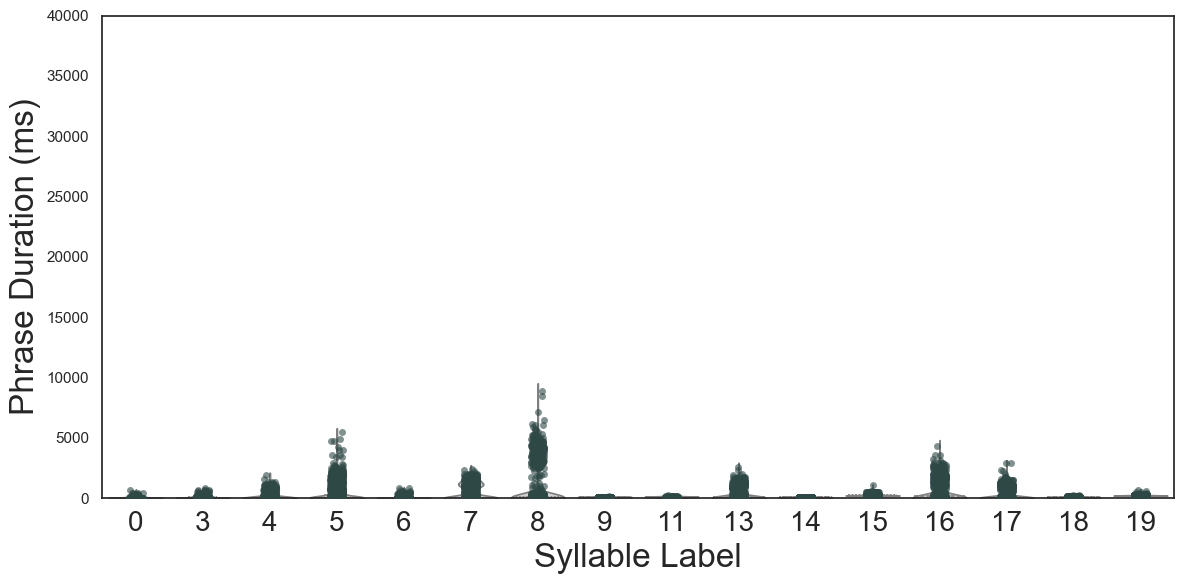

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_28492/1127871989.py:31: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Syllable', y='Phrase Duration (ms)', data=plot_data, inner="quartile", scale="width", color="lightgray")


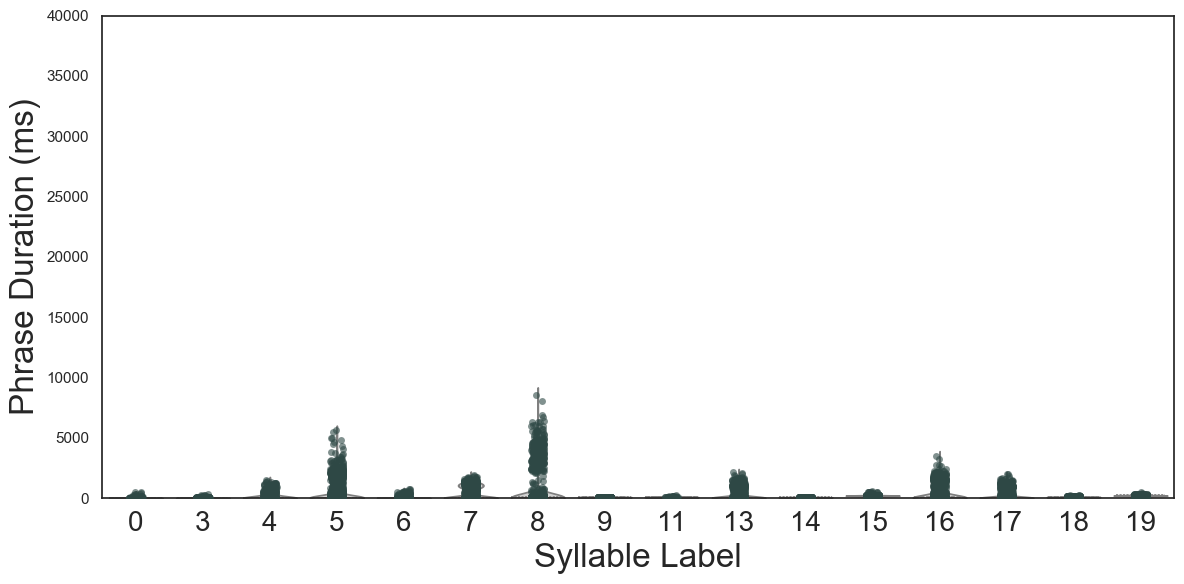

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_syllable_phrase_durations(dataset, unique_syllable_labels, title_suffix, y_min, y_max, group_size, animal_id, save_output_to_this_file_path):
    # Set up the plotting environment
    plt.figure(figsize=(12, 6))
    sns.set(style="white")  # Remove gridlines

    # Prepare data for plotting
    plot_data = pd.DataFrame()

    for syllable_label in unique_syllable_labels:
        # Create the column name based on the syllable label
        column_name = f'syllable_{syllable_label}_durations'
        
        # If the column exists in the dataset, add it to the plot data
        if column_name in dataset.columns:
            # Explode the data for plotting, reset index to avoid duplicate labels, and add a 'Syllable' column for x-axis labels
            exploded_data = dataset[['Date', column_name]].explode(column_name).dropna().reset_index(drop=True)
            exploded_data['Syllable'] = int(syllable_label)  # Convert to integer for proper sorting
            exploded_data['Phrase Duration (ms)'] = pd.to_numeric(exploded_data[column_name], errors='coerce')
            
            # Concatenate exploded data with the main plot data, reset index to avoid issues with duplicate labels
            plot_data = pd.concat([plot_data, exploded_data[['Syllable', 'Phrase Duration (ms)']]], axis=0).reset_index(drop=True)

    # Sort syllables numerically before plotting
    plot_data = plot_data.sort_values(by='Syllable')

    # Create the violin plot to show the distribution of phrase durations for each syllable
    sns.violinplot(x='Syllable', y='Phrase Duration (ms)', data=plot_data, inner="quartile", scale="width", color="lightgray")

    # Overlay a scatterplot on top of the violin plot (using the specified green color and transparency)
    sns.stripplot(x='Syllable', y='Phrase Duration (ms)', data=plot_data, jitter=True, size=5, color="#2E4845", alpha=0.6)

    # Set the y-axis limits to the common y-axis range
    plt.ylim(y_min, y_max)

    # Customize the plot
    #plt.title(f'Distribution of Phrase Durations for Each Syllable {title_suffix} (N={group_size} songs) - {animal_id}', fontsize=18)
    plt.xlabel('Syllable Label', fontsize=24)
    plt.ylabel('Phrase Duration (ms)', fontsize=24)
    plt.ylim(0, 40000)
    plt.xticks(fontsize = 20)  # Rotate x-tick labels for readability

    # Save the plot as a file
    output_file_name = f"{save_output_to_this_file_path}/{animal_id}_{title_suffix}_phrase_durations.png"
    plt.tight_layout()
    
    plt.savefig(output_file_name, format='png', dpi=300, transparent=True)

    # Show the plot
    plt.show()

# Calculate global y-axis range across all datasets
def calculate_y_axis_range(datasets, unique_syllable_labels):
    all_durations = []

    for dataset in datasets:
        for syllable_label in unique_syllable_labels:
            column_name = f'syllable_{syllable_label}_durations'
            if column_name in dataset.columns:
                # Collect all phrase durations
                all_durations.extend(dataset[column_name].explode().dropna().tolist())

    # Determine the global min and max for y-axis limits
    y_min = min(all_durations)
    y_max = max(all_durations)
    
    return y_min, y_max

# Example usage: Calculate y-axis limits and plot for each dataset
datasets = [early_pre_lesion, late_pre_lesion, post_lesion]
y_min, y_max = calculate_y_axis_range(datasets, unique_syllable_labels)

# Get the group size (number of songs) for each dataset
early_group_size = early_pre_lesion.shape[0]
late_group_size = late_pre_lesion.shape[0]
post_group_size = post_lesion.shape[0]

# Generate the graphs for early, late, and post-lesion datasets with the same y-axis scale
plot_syllable_phrase_durations(early_pre_lesion, unique_syllable_labels, "Early Pre-Lesion", y_min, y_max, early_group_size, animal_id, save_output_to_this_file_path)
plot_syllable_phrase_durations(late_pre_lesion, unique_syllable_labels, "Late Pre-Lesion", y_min, y_max, late_group_size, animal_id, save_output_to_this_file_path)
plot_syllable_phrase_durations(post_lesion, unique_syllable_labels, "Post-Lesion", y_min, y_max, post_group_size, animal_id, save_output_to_this_file_path)

## Optional (use if doing PSTs): Generate  graphs with the mapped labels of the PST graphs

In [13]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Define the label-to-character mapping
# label_to_character_mapping = {
#     0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 
#     10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 
#     19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'a', 27: 'b', 
#     28: 'c', 29: 'd', 30: 'e', 31: 'f', 32: 'g', 33: 'h', 34: 'i', 35: 'j', 36: 'k', 
#     37: 'l', 38: 'm', 39: 'n', 40: 'o', 41: 'p', 42: 'q', 43: 'r', 44: 's', 45: 't', 
#     46: 'u', 47: 'v', 48: 'w', 49: 'x', 50: 'y', 51: 'z', 52: '0', 53: '1', 54: '2', 
#     55: '3', 56: '4', 57: '5', 58: '6', 59: '7', 60: '8', 61: '9'
# }

# def plot_syllable_phrase_durations(dataset, unique_syllable_labels, title_suffix, y_min, y_max, group_size, animal_id, save_output_to_this_file_path):
#     # Set up the plotting environment
#     plt.figure(figsize=(12, 6))
#     sns.set(style="white")  # Remove gridlines

#     # Prepare data for plotting
#     plot_data = pd.DataFrame()

#     for syllable_label in unique_syllable_labels:
#         # Create the column name based on the syllable label
#         column_name = f'syllable_{syllable_label}_durations'
        
#         # If the column exists in the dataset, add it to the plot data
#         if column_name in dataset.columns:
#             # Explode the data for plotting, reset index to avoid duplicate labels, and add a 'Syllable' column for x-axis labels
#             exploded_data = dataset[['Date', column_name]].explode(column_name).dropna().reset_index(drop=True)
#             exploded_data['Syllable'] = int(syllable_label)  # Convert to integer for proper sorting
#             exploded_data['Phrase Duration (ms)'] = pd.to_numeric(exploded_data[column_name], errors='coerce')
            
#             # Concatenate exploded data with the main plot data, reset index to avoid issues with duplicate labels
#             plot_data = pd.concat([plot_data, exploded_data[['Syllable', 'Phrase Duration (ms)']]], axis=0).reset_index(drop=True)

#     # Sort syllables numerically before plotting
#     plot_data = plot_data.sort_values(by='Syllable')

#     # Create the violin plot to show the distribution of phrase durations for each syllable
#     sns.violinplot(x='Syllable', y='Phrase Duration (ms)', data=plot_data, inner="quartile", scale="width", color="lightgray")

#     # Overlay a scatterplot on top of the violin plot (using the specified green color and transparency)
#     sns.stripplot(x='Syllable', y='Phrase Duration (ms)', data=plot_data, jitter=True, size=5, color="#2E4845", alpha=0.6)

#     # Set the y-axis limits to the common y-axis range
#     plt.ylim(y_min, y_max)

#     # Customize the plot
#     plt.xlabel('Syllable Label', fontsize=24)
#     plt.ylabel('Phrase Duration (ms)', fontsize=24)
#     plt.ylim(0, 40000)
    
#     # Replace numerical syllable labels with characters on the x-axis using the label-to-character mapping
#     syllable_ticks = [label_to_character_mapping.get(label, str(label)) for label in sorted(plot_data['Syllable'].unique())]
#     plt.xticks(ticks=range(len(syllable_ticks)), labels=syllable_ticks, fontsize = 20)  # Set custom x-tick labels

#     # Save the plot as a file
#     output_file_name = f"{save_output_to_this_file_path}/{animal_id}_{title_suffix}_phrase_durations.png"
#     plt.tight_layout()
#     plt.savefig(output_file_name, format='png', dpi=300)
#     #plt.savefig(output_file_name, format='png', dpi=300, transparent=True)

#     # Show the plot
#     plt.show()

# # Calculate global y-axis range across all datasets
# def calculate_y_axis_range(datasets, unique_syllable_labels):
#     all_durations = []

#     for dataset in datasets:
#         for syllable_label in unique_syllable_labels:
#             column_name = f'syllable_{syllable_label}_durations'
#             if column_name in dataset.columns:
#                 # Collect all phrase durations
#                 all_durations.extend(dataset[column_name].explode().dropna().tolist())

#     # Determine the global min and max for y-axis limits
#     y_min = min(all_durations)
#     y_max = max(all_durations)
    
#     return y_min, y_max

# # Example usage: Calculate y-axis limits and plot for each dataset
# datasets = [early_pre_lesion, late_pre_lesion, post_lesion]
# y_min, y_max = calculate_y_axis_range(datasets, unique_syllable_labels)

# # Get the group size (number of songs) for each dataset
# early_group_size = early_pre_lesion.shape[0]
# late_group_size = late_pre_lesion.shape[0]
# post_group_size = post_lesion.shape[0]

# # Generate the graphs for early, late, and post-lesion datasets with the same y-axis scale
# plot_syllable_phrase_durations(early_pre_lesion, unique_syllable_labels, "Early Pre-Lesion", y_min, y_max, early_group_size, animal_id, save_output_to_this_file_path)
# plot_syllable_phrase_durations(late_pre_lesion, unique_syllable_labels, "Late Pre-Lesion", y_min, y_max, late_group_size, animal_id, save_output_to_this_file_path)
# plot_syllable_phrase_durations(post_lesion, unique_syllable_labels, "Post-Lesion", y_min, y_max, post_group_size, animal_id, save_output_to_this_file_path)


## Ignore the following combined graphing code

In [14]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# def plot_combined_syllable_phrase_durations(early_pre_lesion, late_pre_lesion, post_lesion, unique_syllable_labels, group_size, animal_id, save_output_to_this_file_path):
#     # Prepare a combined DataFrame with an additional 'Stage' column
#     combined_data = pd.DataFrame()

#     # Define a function to prepare each dataset with a 'Stage' label
#     def prepare_dataset_for_plot(dataset, stage_label):
#         stage_data = pd.DataFrame()
#         for syllable_label in unique_syllable_labels:
#             column_name = f'syllable_{syllable_label}_durations'
#             if column_name in dataset.columns:
#                 exploded_data = dataset[['Date', column_name]].explode(column_name).dropna().reset_index(drop=True)
#                 exploded_data['Syllable'] = int(syllable_label)  # Convert to integer for proper sorting
#                 exploded_data['Phrase Duration (ms)'] = pd.to_numeric(exploded_data[column_name], errors='coerce')
#                 exploded_data['Stage'] = stage_label  # Add the stage label (early, late, post)
                
#                 # Concatenate to the stage_data DataFrame
#                 stage_data = pd.concat([stage_data, exploded_data[['Syllable', 'Phrase Duration (ms)', 'Stage']]], axis=0).reset_index(drop=True)
#         return stage_data

#     # Prepare each dataset with its corresponding stage
#     early_data = prepare_dataset_for_plot(early_pre_lesion, "Early Pre-Lesion")
#     late_data = prepare_dataset_for_plot(late_pre_lesion, "Late Pre-Lesion")
#     post_data = prepare_dataset_for_plot(post_lesion, "Post-Lesion")

#     # Combine all the datasets into one DataFrame
#     combined_data = pd.concat([early_data, late_data, post_data], axis=0).reset_index(drop=True)

#     # Plot the combined violin plot with stage labels
#     plt.figure(figsize=(20, 8))
#     sns.set(style="whitegrid")

#     # Create the violin plot with hue as 'Stage' to color-code the stages
#     sns.violinplot(x='Syllable', y='Phrase Duration (ms)', hue='Stage', data=combined_data, 
#                    split=True, inner="quartile", scale="width", palette="Set2")

#     # Customize the plot
#     plt.title(f'Distribution of Phrase Durations for Each Syllable from Early, Late Pre-Lesion, and Post-Lesion (N={group_size} songs) - {animal_id}', fontsize=18)
#     plt.xlabel('Syllable Label', fontsize=24)
#     plt.ylim(0, 25000)
#     plt.ylabel('Phrase Duration (ms)', fontsize=24)
#     plt.xticks(rotation=90)  # Rotate x-tick labels for readability
#     plt.legend(title='Stage')

#     # Save the plot as a file
#     output_file_name = f"{save_output_to_this_file_path}/{animal_id}_combined_phrase_durations.png"
#     plt.tight_layout()
#     plt.savefig(output_file_name, format='png', dpi=300)

#     # Show the plot
#     plt.show()

# # Example usage
# plot_combined_syllable_phrase_durations(early_pre_lesion, late_pre_lesion, post_lesion, unique_syllable_labels, group_size, animal_id, save_output_to_this_file_path)


In [15]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# def plot_combined_syllable_phrase_durations(early_pre_lesion, late_pre_lesion, post_lesion, unique_syllable_labels):
#     # Prepare a combined DataFrame with an additional 'Stage' column
#     combined_data = pd.DataFrame()

#     # Define a function to prepare each dataset with a 'Stage' label
#     def prepare_dataset_for_plot(dataset, stage_label):
#         stage_data = pd.DataFrame()
#         for syllable_label in unique_syllable_labels:
#             column_name = f'syllable_{syllable_label}_durations'
#             if column_name in dataset.columns:
#                 exploded_data = dataset[['Date', column_name]].explode(column_name).dropna().reset_index(drop=True)
#                 exploded_data['Syllable'] = int(syllable_label)  # Convert to integer for proper sorting
#                 exploded_data['Phrase Duration (ms)'] = pd.to_numeric(exploded_data[column_name], errors='coerce')
#                 exploded_data['Stage'] = stage_label  # Add the stage label (early, late, post)
                
#                 # Concatenate to the stage_data DataFrame
#                 stage_data = pd.concat([stage_data, exploded_data[['Syllable', 'Phrase Duration (ms)', 'Stage']]], axis=0).reset_index(drop=True)
#         return stage_data

#     # Prepare each dataset with its corresponding stage
#     early_data = prepare_dataset_for_plot(early_pre_lesion, "Early Pre-Lesion")
#     late_data = prepare_dataset_for_plot(late_pre_lesion, "Late Pre-Lesion")
#     post_data = prepare_dataset_for_plot(post_lesion, "Post-Lesion")

#     # Combine all the datasets into one DataFrame
#     combined_data = pd.concat([early_data, late_data, post_data], axis=0).reset_index(drop=True)

#     # Plot the combined scatter and violin plot with stage labels
#     plt.figure(figsize=(20, 8))  # Increased width to allow more space for syllable labels
#     sns.set(style="whitegrid")

#     # Overlay scatterplots first for each stage (make them fainter with lower alpha)
#     sns.stripplot(x='Syllable', y='Phrase Duration (ms)', hue='Stage', data=combined_data, 
#                   dodge=True, jitter=True, size=5, alpha=0.1, palette="Set2", linewidth=0.5)

#     # Now overlay the violin plots on top (fully opaque)
#     sns.violinplot(x='Syllable', y='Phrase Duration (ms)', hue='Stage', data=combined_data, 
#                    split=True, inner="quartile", scale="width", palette="Set2", alpha=1, dodge=True)

#     # Customize the plot
#     plt.title('Distribution of Phrase Durations for Each Syllable (Early, Late, and Post-Lesion)', fontsize=18)
#     plt.xlabel('Syllable Label', fontsize=14)
#     plt.ylabel('Phrase Duration (ms)', fontsize=14)
#     plt.xticks(rotation=90)  # Rotate x-tick labels for readability
#     plt.legend(title='Stage')

#     # Show the plot
#     plt.tight_layout()
#     plt.show()

# # Example usage
# plot_combined_syllable_phrase_durations(early_pre_lesion, late_pre_lesion, post_lesion, unique_syllable_labels)


In [16]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import numpy as np

# def plot_combined_syllable_phrase_durations(early_pre_lesion, late_pre_lesion, post_lesion, unique_syllable_labels):
#     # Convert unique_syllable_labels to a sorted list to access indices
#     unique_syllable_labels = sorted(list(unique_syllable_labels))

#     # Prepare a combined DataFrame with an additional 'Stage' column
#     combined_data = pd.DataFrame()

#     # Define a function to prepare each dataset with a 'Stage' label
#     def prepare_dataset_for_plot(dataset, stage_label):
#         stage_data = pd.DataFrame()
#         for syllable_label in unique_syllable_labels:
#             column_name = f'syllable_{syllable_label}_durations'
#             if column_name in dataset.columns:
#                 exploded_data = dataset[['Date', column_name]].explode(column_name).dropna().reset_index(drop=True)
#                 exploded_data['Syllable'] = int(syllable_label)  # Convert to integer for proper sorting
#                 exploded_data['Phrase Duration (ms)'] = pd.to_numeric(exploded_data[column_name], errors='coerce')
#                 exploded_data['Stage'] = stage_label  # Add the stage label (early, late, post)
                
#                 # Concatenate to the stage_data DataFrame
#                 stage_data = pd.concat([stage_data, exploded_data[['Syllable', 'Phrase Duration (ms)', 'Stage']]], axis=0).reset_index(drop=True)
#         return stage_data

#     # Prepare each dataset with its corresponding stage
#     early_data = prepare_dataset_for_plot(early_pre_lesion, "Early Pre-Lesion")
#     late_data = prepare_dataset_for_plot(late_pre_lesion, "Late Pre-Lesion")
#     post_data = prepare_dataset_for_plot(post_lesion, "Post-Lesion")

#     # Combine all the datasets into one DataFrame
#     combined_data = pd.concat([early_data, late_data, post_data], axis=0).reset_index(drop=True)

#     # Plot the combined box plot with stage labels
#     plt.figure(figsize=(20, 8))  # Increased width to allow more space for syllable labels
#     sns.set(style="whitegrid")

#     # Create the box plot with stage labels
#     sns.boxplot(x='Syllable', y='Phrase Duration (ms)', hue='Stage', data=combined_data, 
#                 palette="Set2", dodge=True, showmeans=True, meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black", "markersize": 7})

#     # Customize the plot
#     plt.title('Distribution of Phrase Durations for Each Syllable (Early, Late, and Post-Lesion)', fontsize=18)
#     plt.xlabel('Syllable Label', fontsize=14)
#     plt.ylabel('Phrase Duration (ms)', fontsize=14)
#     plt.xticks(rotation=90)  # Rotate x-tick labels for readability
#     plt.legend(title='Stage')

#     # Show the plot
#     plt.tight_layout()
#     plt.show()

# # Example usage
# plot_combined_syllable_phrase_durations(early_pre_lesion, late_pre_lesion, post_lesion, unique_syllable_labels)


### Step 7: Check for significant differences in distributions by using a K-S for a triplet of syllables' data. 